# Boxplots

## Script setup

In [14]:
# Third-party and standard modules
from typing import Dict, Hashable, Union, Tuple, Optional
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import pytz
from collections import defaultdict
from numpy import NINF
import datetime
from importlib import reload
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
# User-defined modules.
from modules import dataframe_manip as dfm
from modules import misc, schemas, College1AcPtTimeSeries
# The reload() function is used to update modules after
# changes are made to their files.
dfm = reload(dfm)
misc = reload(misc)
schemas = reload(schemas)
College1AcPtTimeSeries = reload(College1AcPtTimeSeries)

## Script parameters

The following values are this script's parameters.

1. `filepath` - path to csv file you would like to analyze
2. `buildings` - the list of buildings you would like to analyze
3. `start_date and end_date` - can be "None" if you wish to analyze the whole dataset
3. `boxplot_hourly_average` - set to true or false, depending if you want to display the total, weekday, and weekend graphs
4. `holiday_analysis` - set to true or false, if you would like to see the average occupancy of the holidays in the given date ranges
5. `schema` - determines how the csv columns should be interpreted.

In [15]:
filepath = './sample_data.csv'
timezone = pytz.timezone('US/Pacific')
buildings = [
    'BUILDING03', 'BUILDING05', 'BUILDING06', 'BUILDING08',
    'BUILDING10', 'BUILDING12', 'BUILDING14'
]

start_date: Optional[str] = None  # '2018-09-04' #None
end_date: Optional[str] = None  #'2018-12-19' #None

boxplot_hourly_average = True
holiday_analysis = True

schema: schemas.AcPtTimeSeries =\
    College1AcPtTimeSeries.College1AcPtTimeSeries

## Data Processing

In [16]:
# A time-series dataframe holding occupancy counts
# for many access points (columns).
occ: pd.DataFrame = dfm.csv_to_timeseries_df(
    filepath=filepath, timezone=timezone
)

In [17]:
# Convert df values to strings in order to compare to given range
csv_start_date = occ.index[0].strftime('%Y-%m-%d')
csv_end_date = occ.index[-1].strftime('%Y-%m-%d')

In [18]:
# Date range error checking
if start_date is not None and end_date is not None:
    if end_date < start_date:
        print("end_date is before start_date")
        exit()

    if start_date < csv_start_date :
        print("Desired start_date is before the first day of the csv, please fix this to continue")
        exit()

    if end_date > csv_end_date:
        print("Desired end_date filter is after the last day of the csv, please fix this to continue")
        exit()

In [19]:
# Apply date range filter on the dataframe
if start_date is not None: 
    if end_date is None:
        occ = occ.loc[start_date:]
    else:
        occ = occ.loc[start_date:end_date]
else:
    if end_date is not None:
        occ = occ.loc[:end_date]

In [20]:
# Eliminate columns for access points not in the buildings we want.
occ = occ.drop(columns=list(filter(
    # add to drop-list if NOT in the buildings we want.
    lambda col: schema.col_to_building(col, safe=True) not in buildings,
    occ.columns.to_list()
)))

# We must assume that intervening na-values are 0's.
occ = dfm.fill_intervening_nas(
    occ, inplace=True, fill_val=0
)

In [21]:
occ_bybuild = occ.groupby(
    by=schema.col_to_building, axis=1
)

In [22]:
print('buildings not found or used: {}'.format(
    set(buildings) - set(occ_bybuild.groups.keys())
))

# We can only work with the buildings we found.
buildings = list(occ_bybuild.groups.keys())
print('buildings being used: {}'.format(buildings))

buildings not found or used: set()
buildings being used: ['BUILDING03', 'BUILDING05', 'BUILDING06', 'BUILDING08', 'BUILDING10', 'BUILDING12', 'BUILDING14']


## Boxplots

In [23]:
def display_and_save_hourly_boxplot(
    tseries: pd.Series, title: str,
    xlabel: str, ylabel: str, ymax: Union[float, int],
    figsize: Tuple[Union[float,int], Union[float,int]],
    figfilepath: str
) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(0, ymax)
    seaborn.boxplot(
        # The hours (a number [0,23]) for each row.
        x=tseries.index.hour,
        # The total occupancy at that hour.
        y=tseries,
        ax=ax
    )

/Users/josalvatorre/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


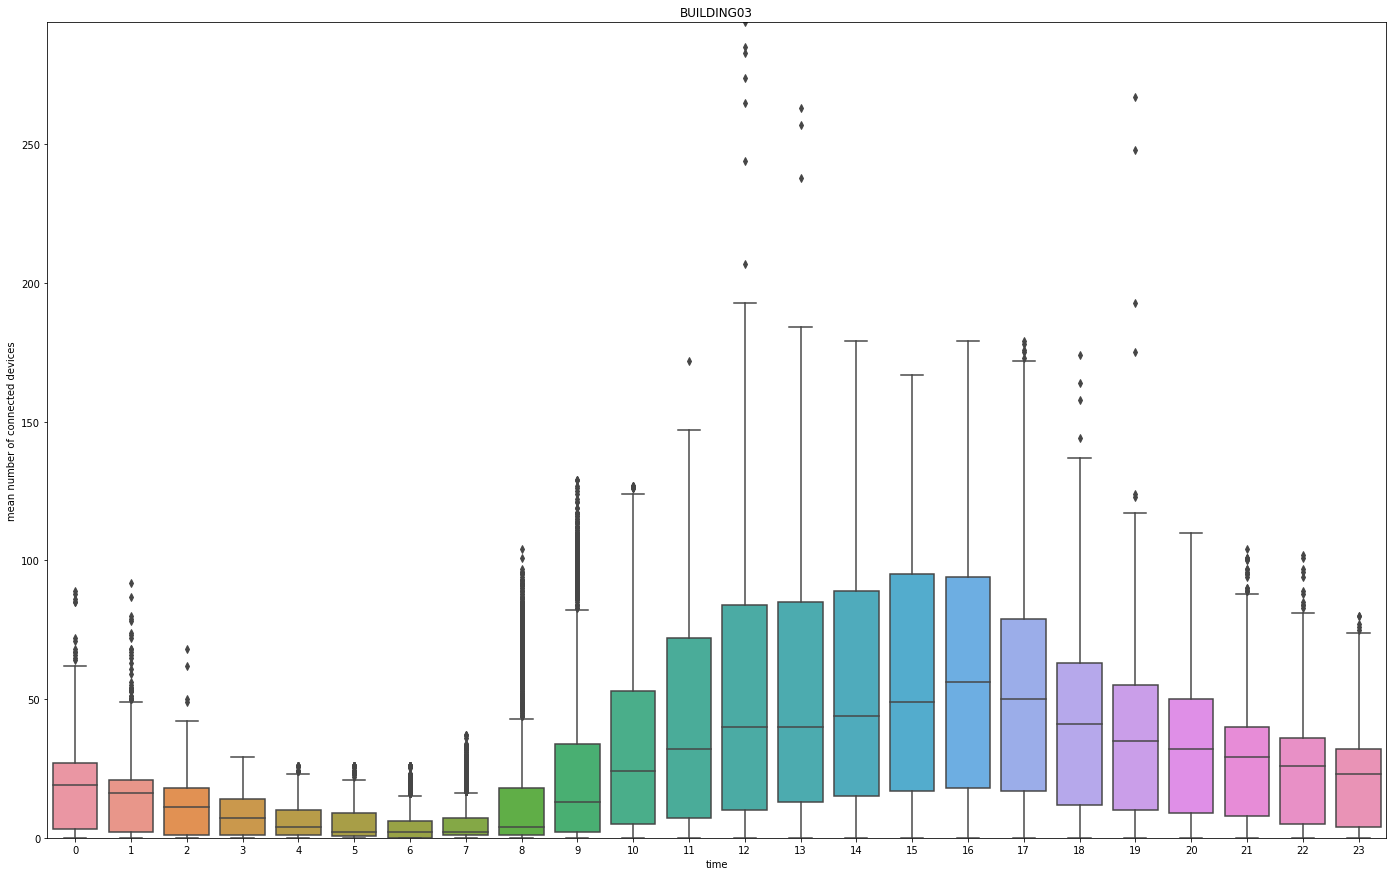

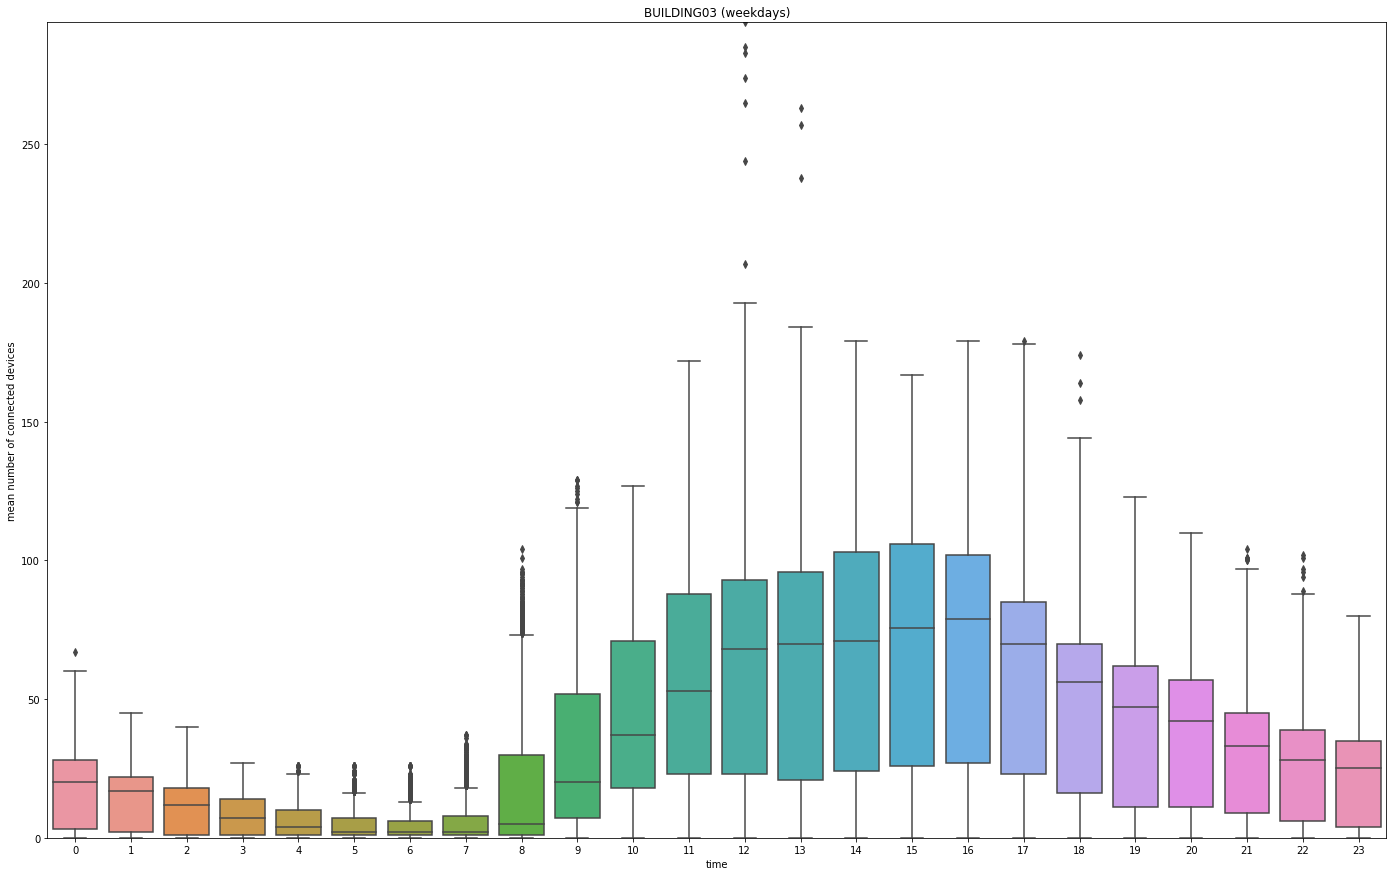

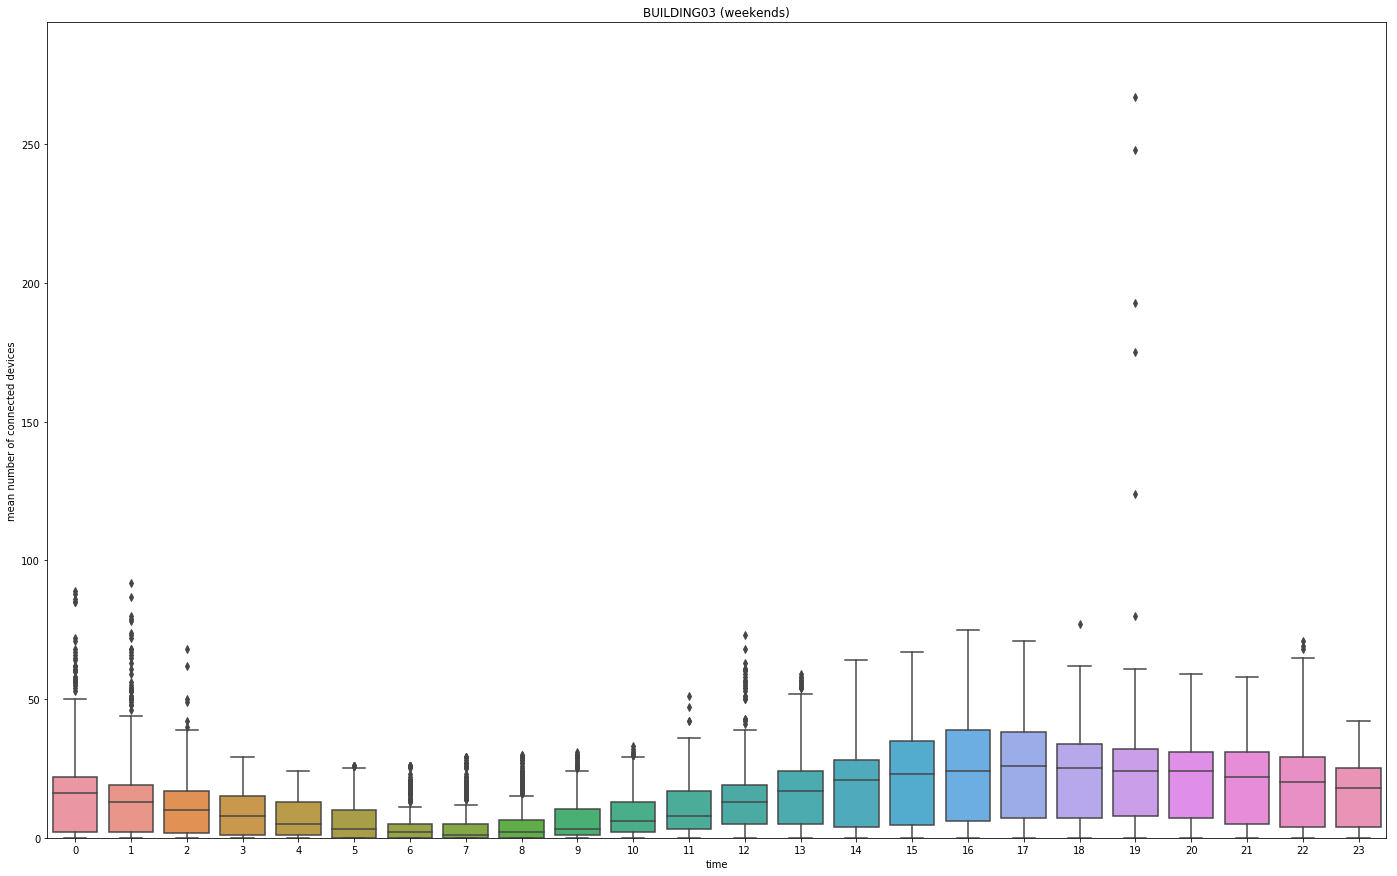

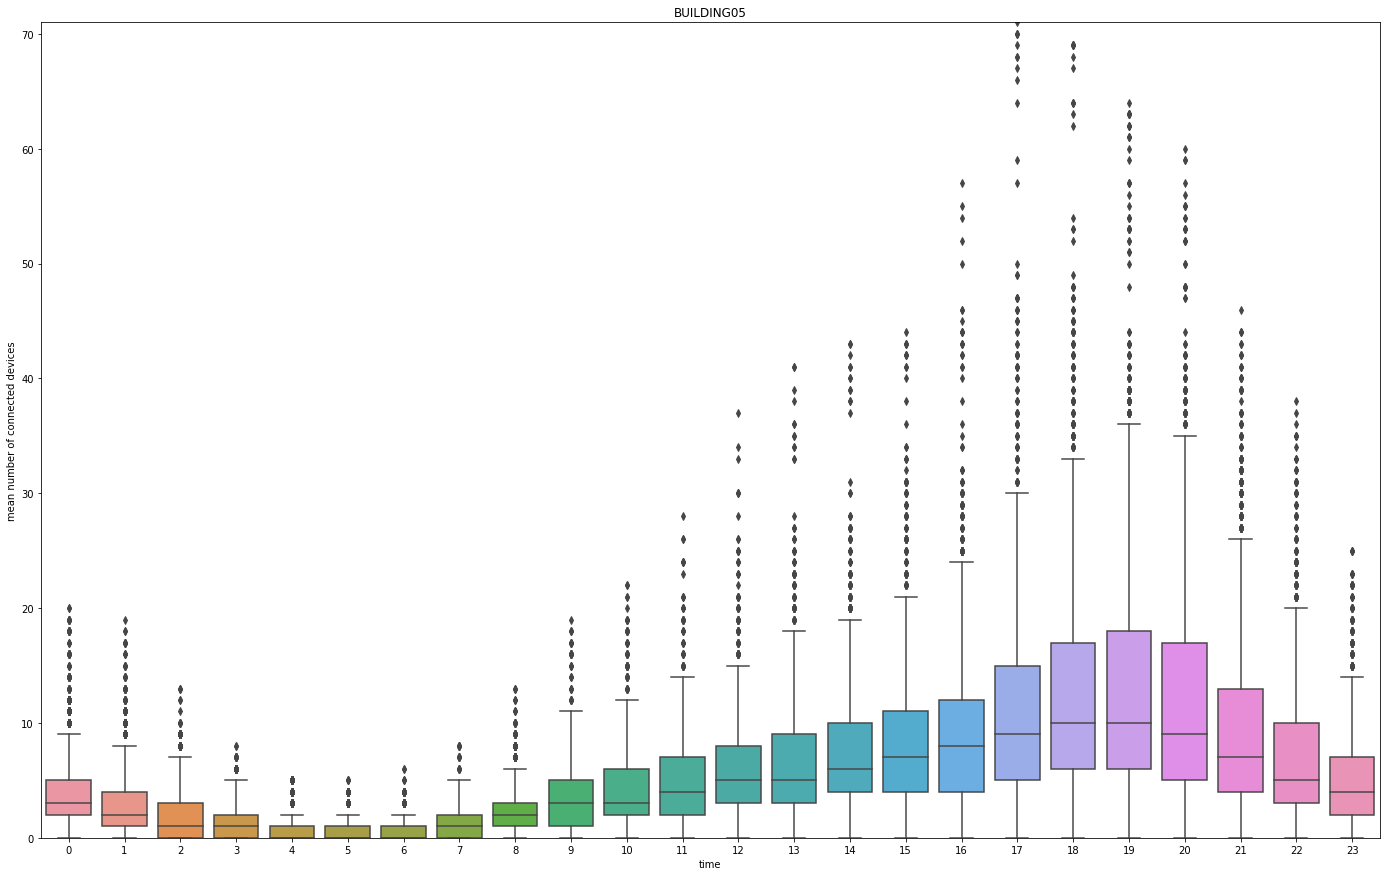

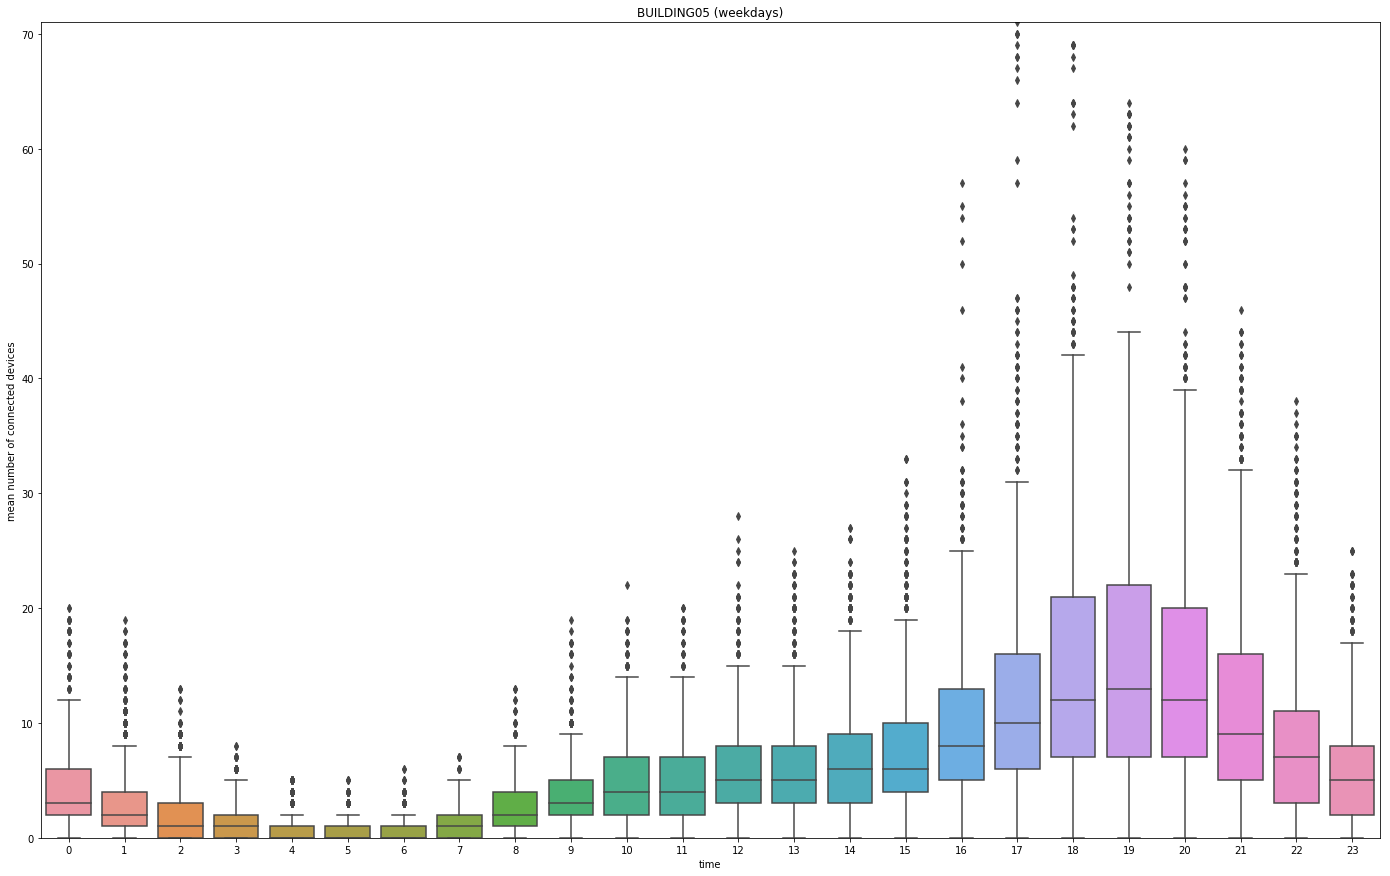

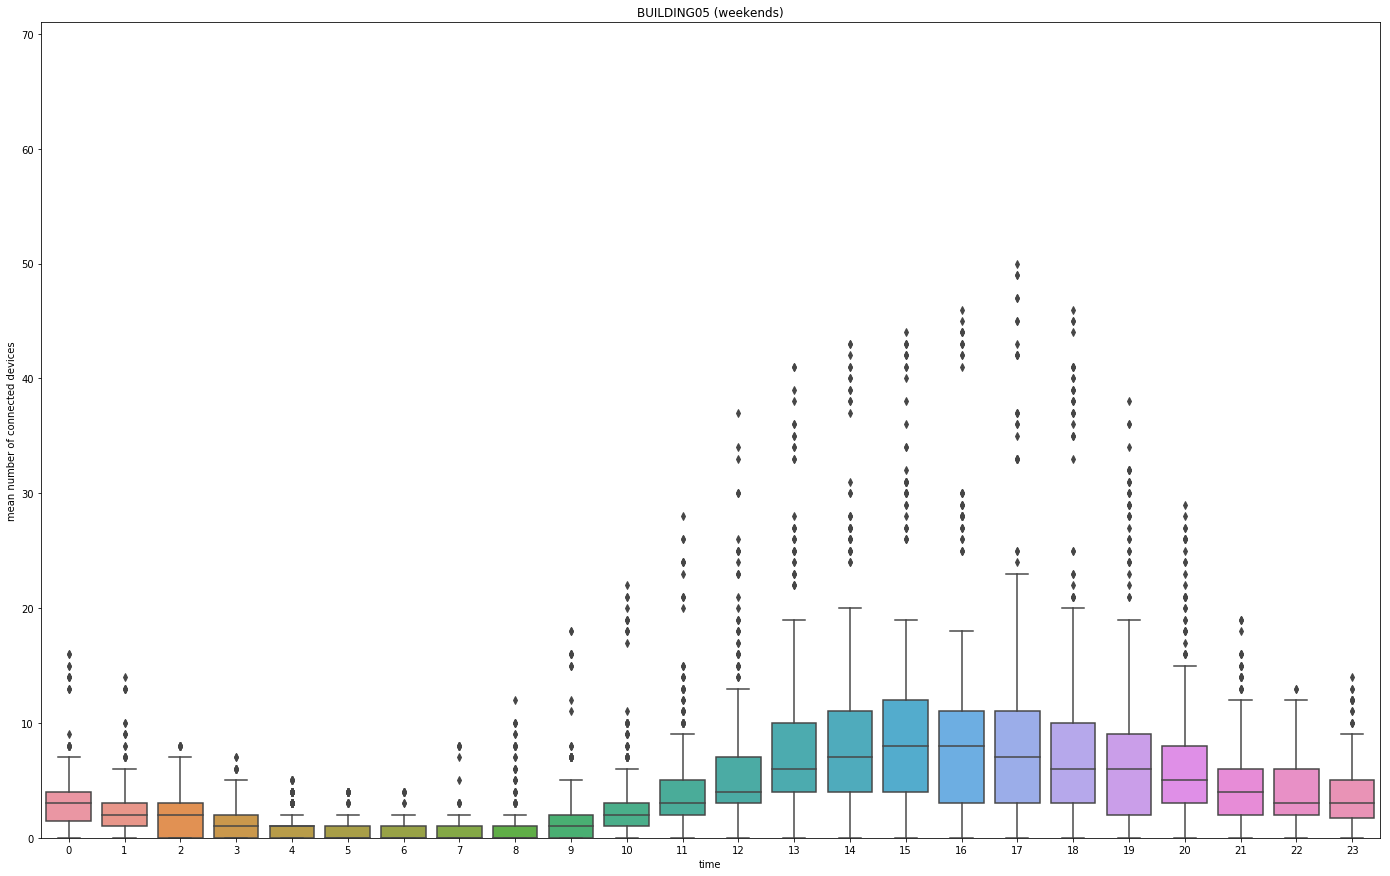

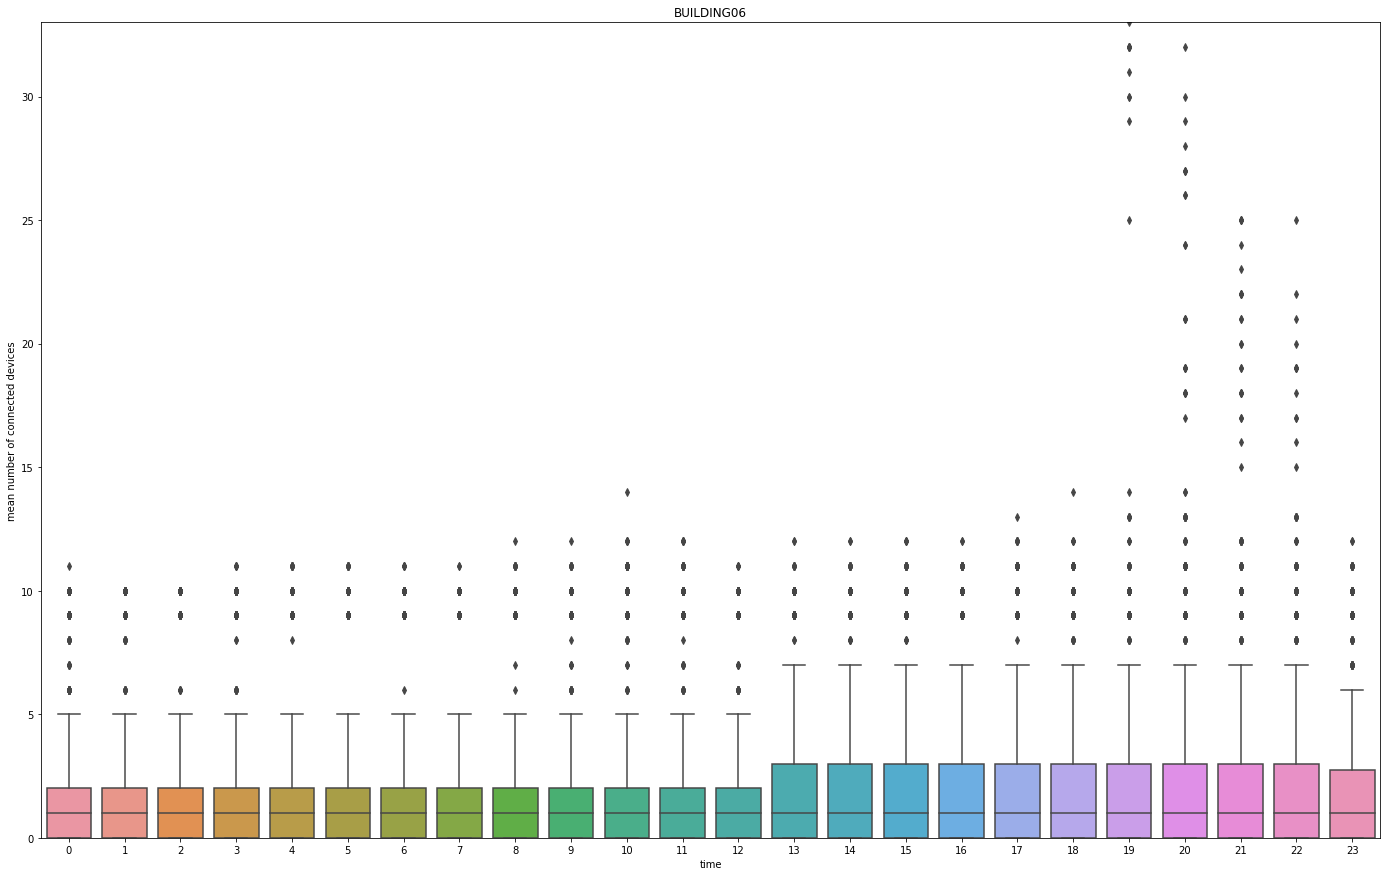

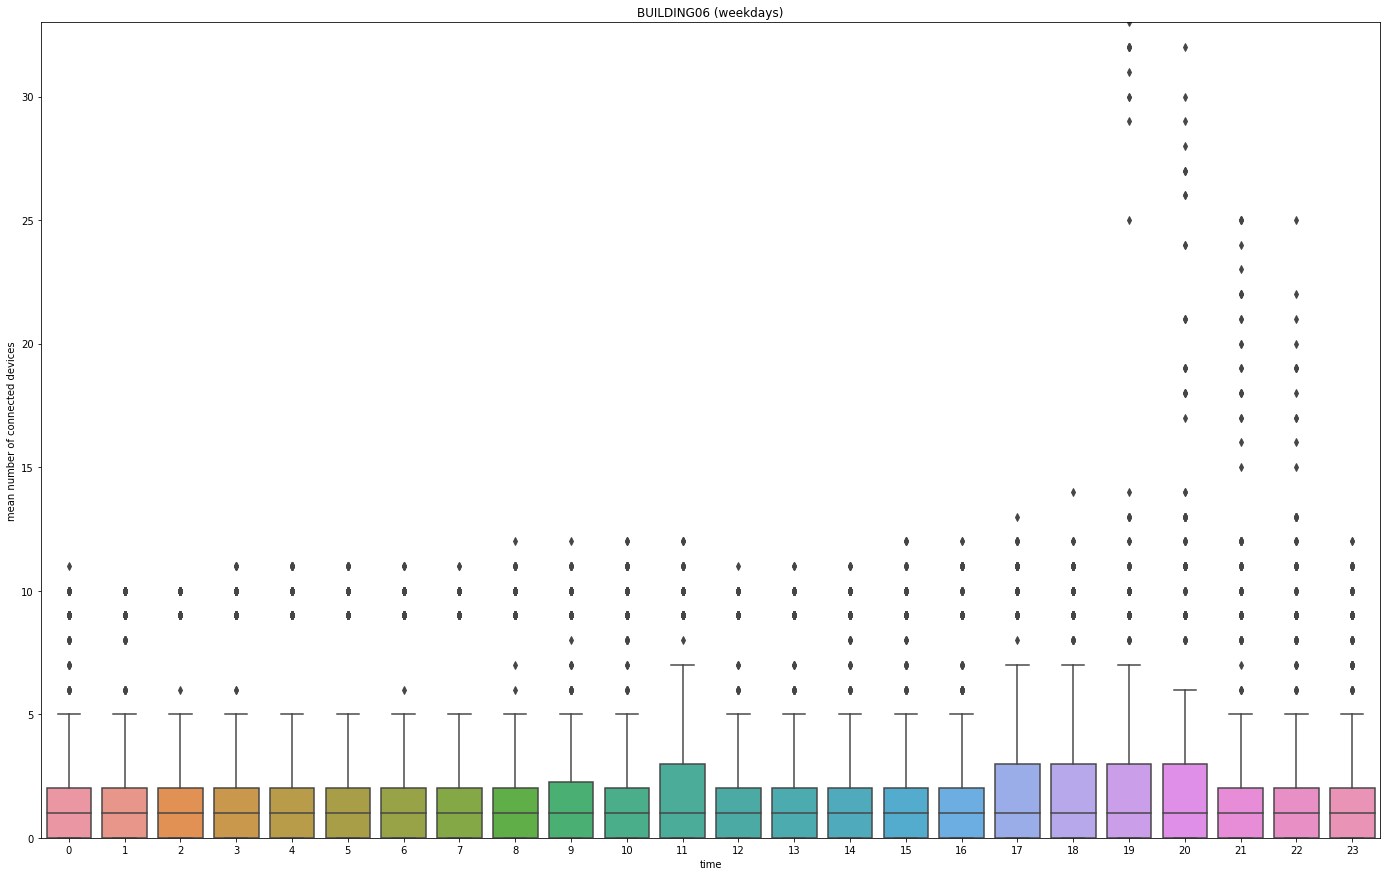

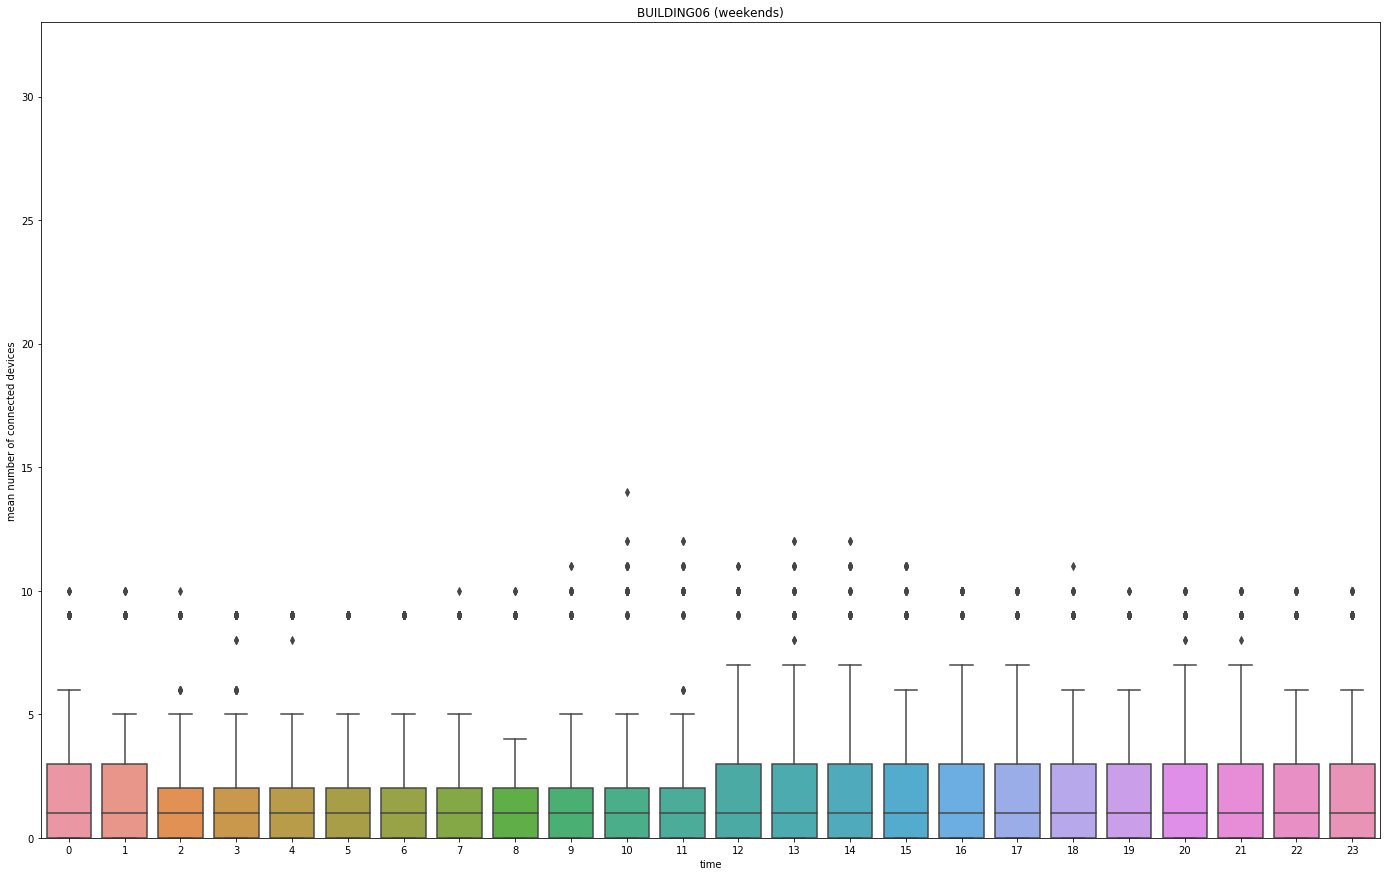

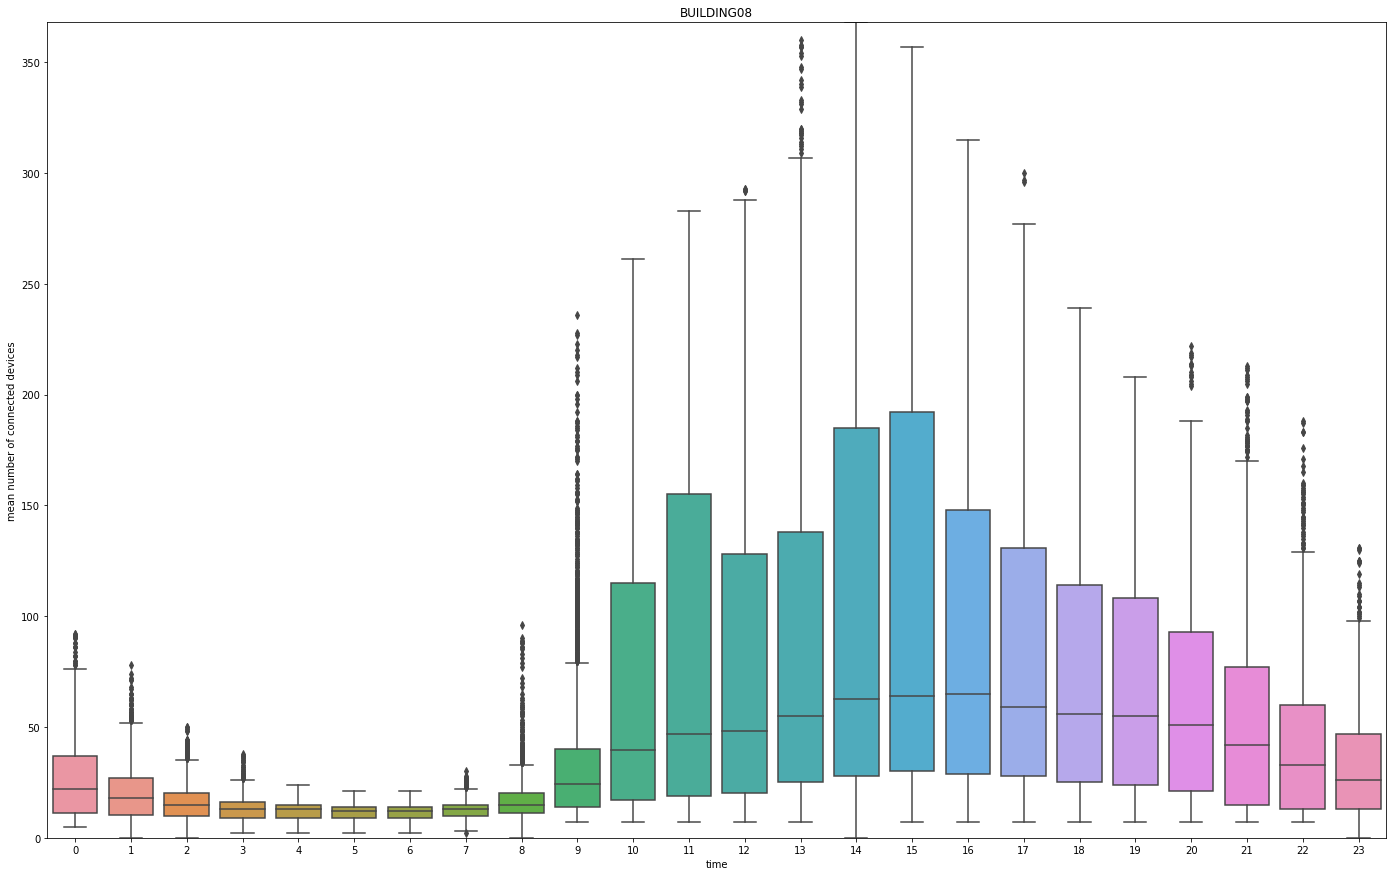

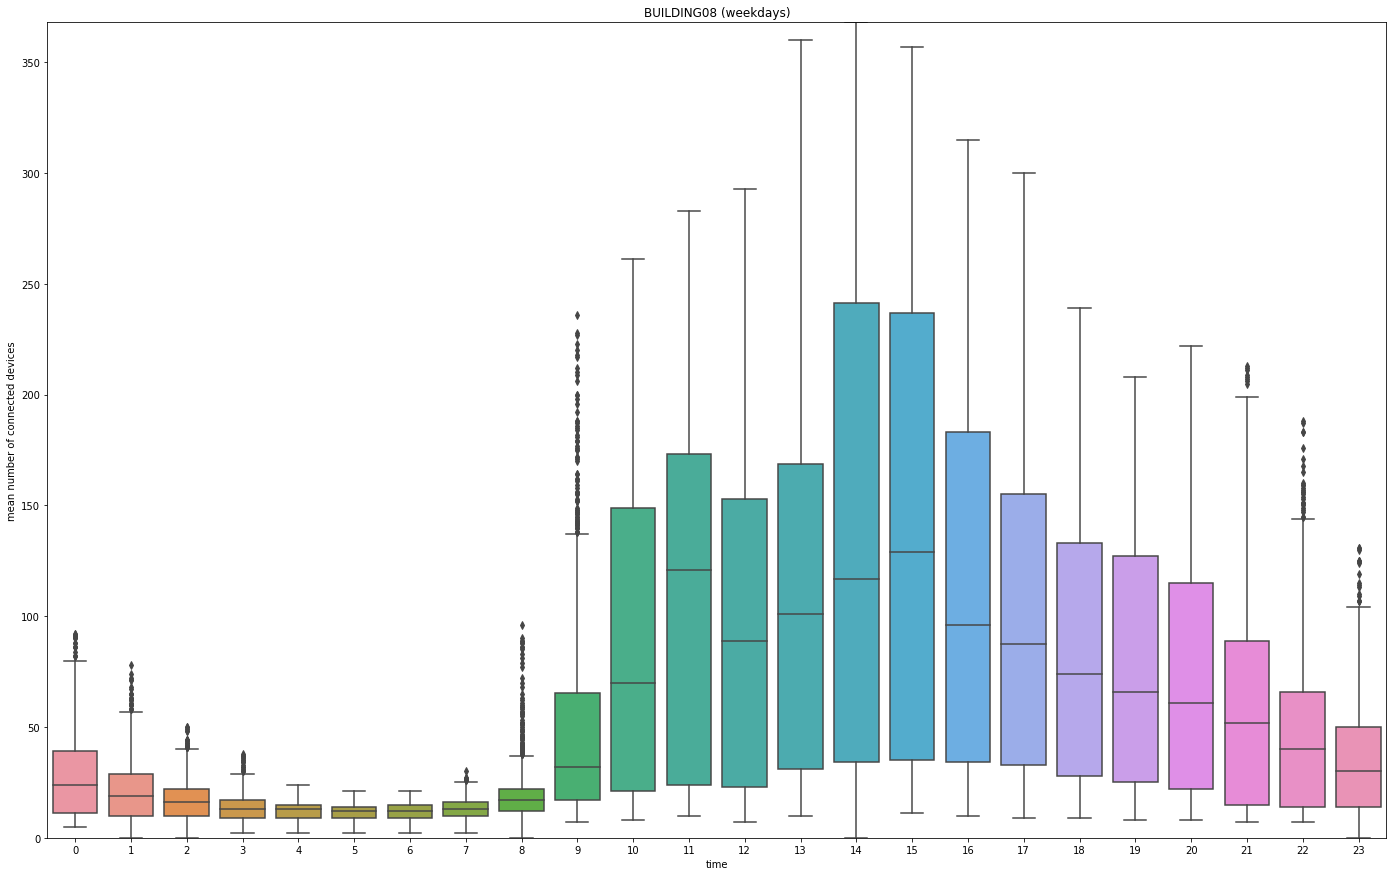

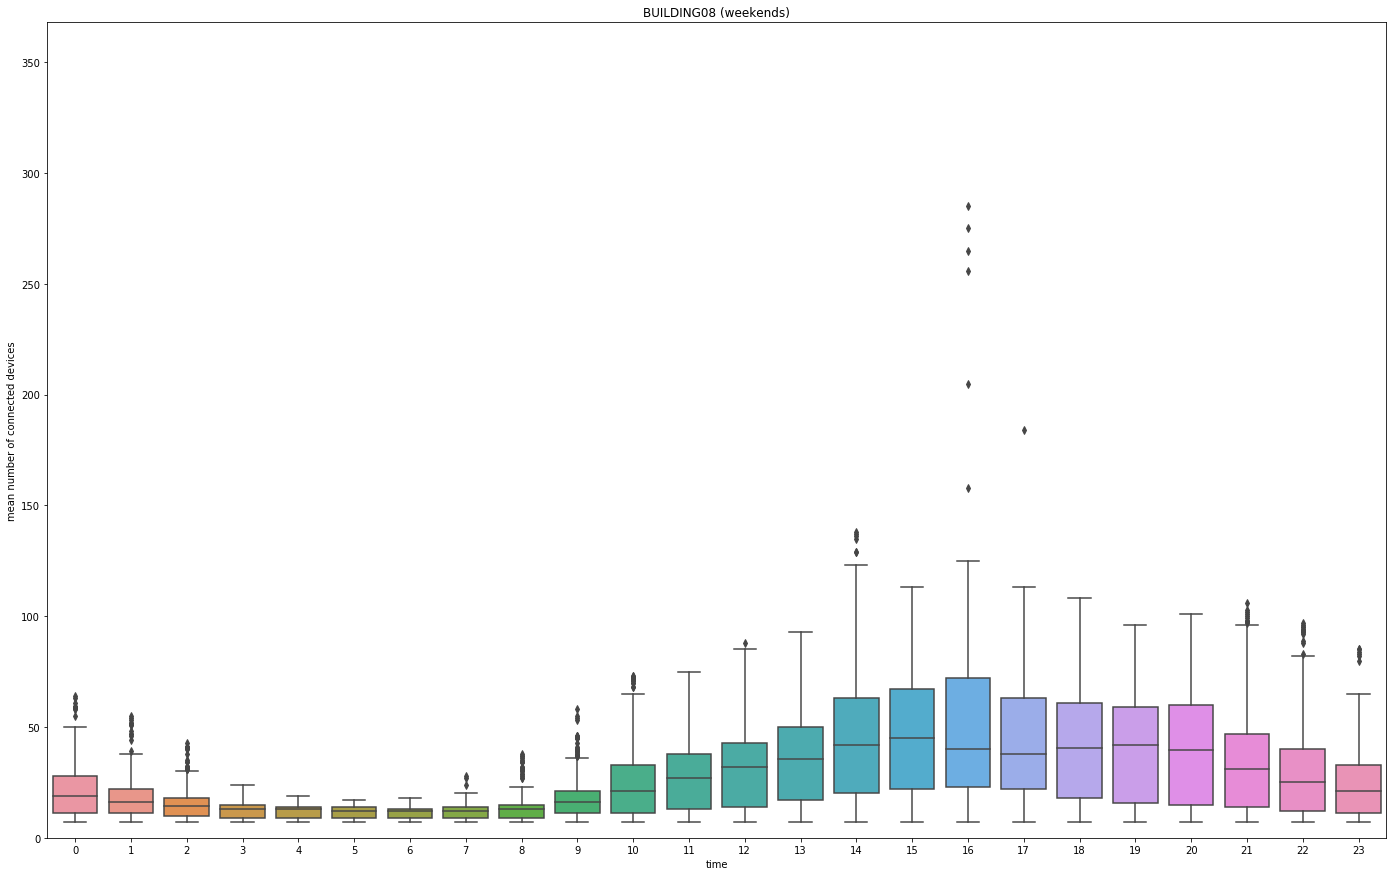

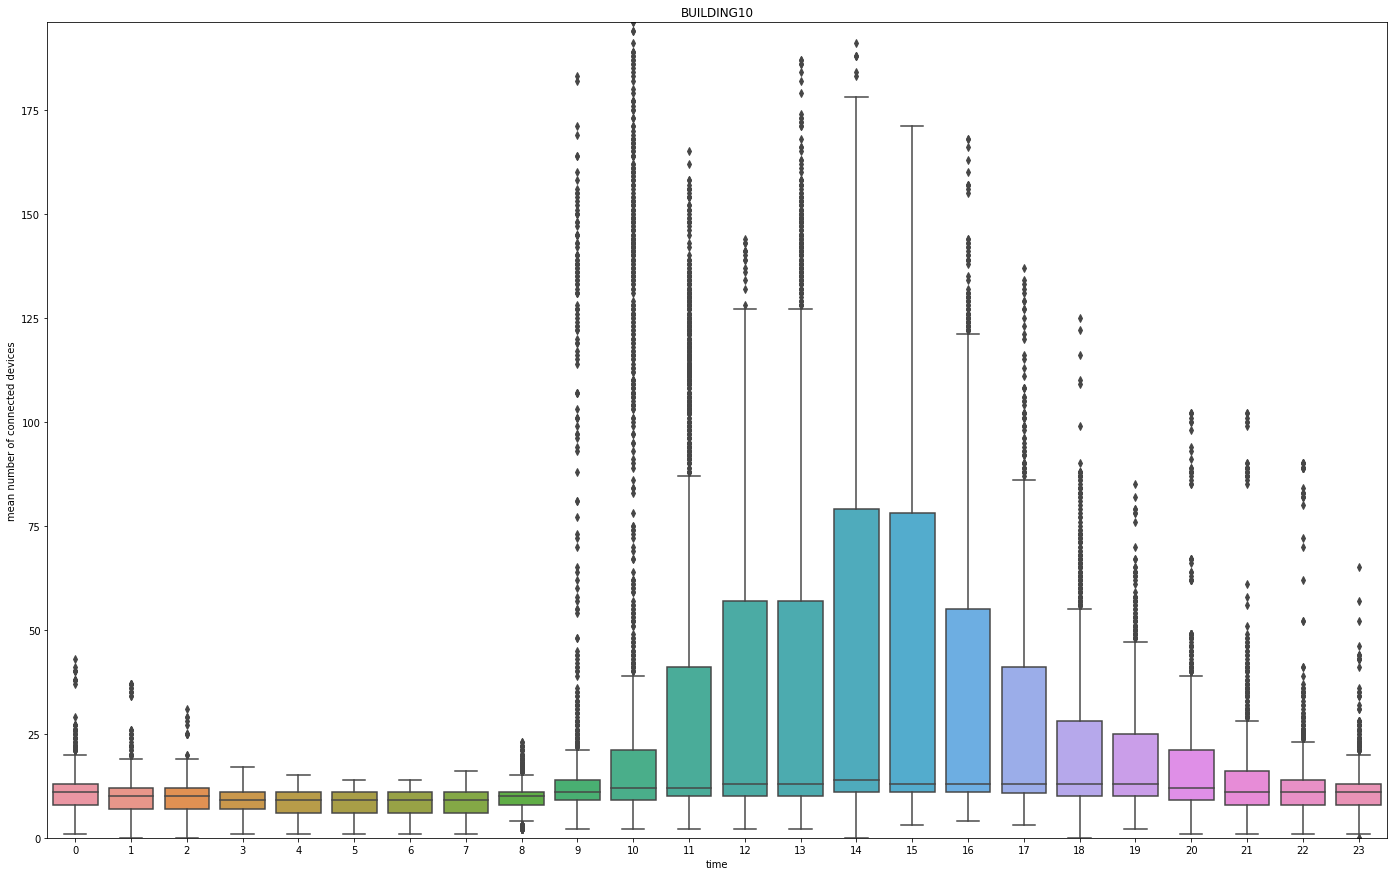

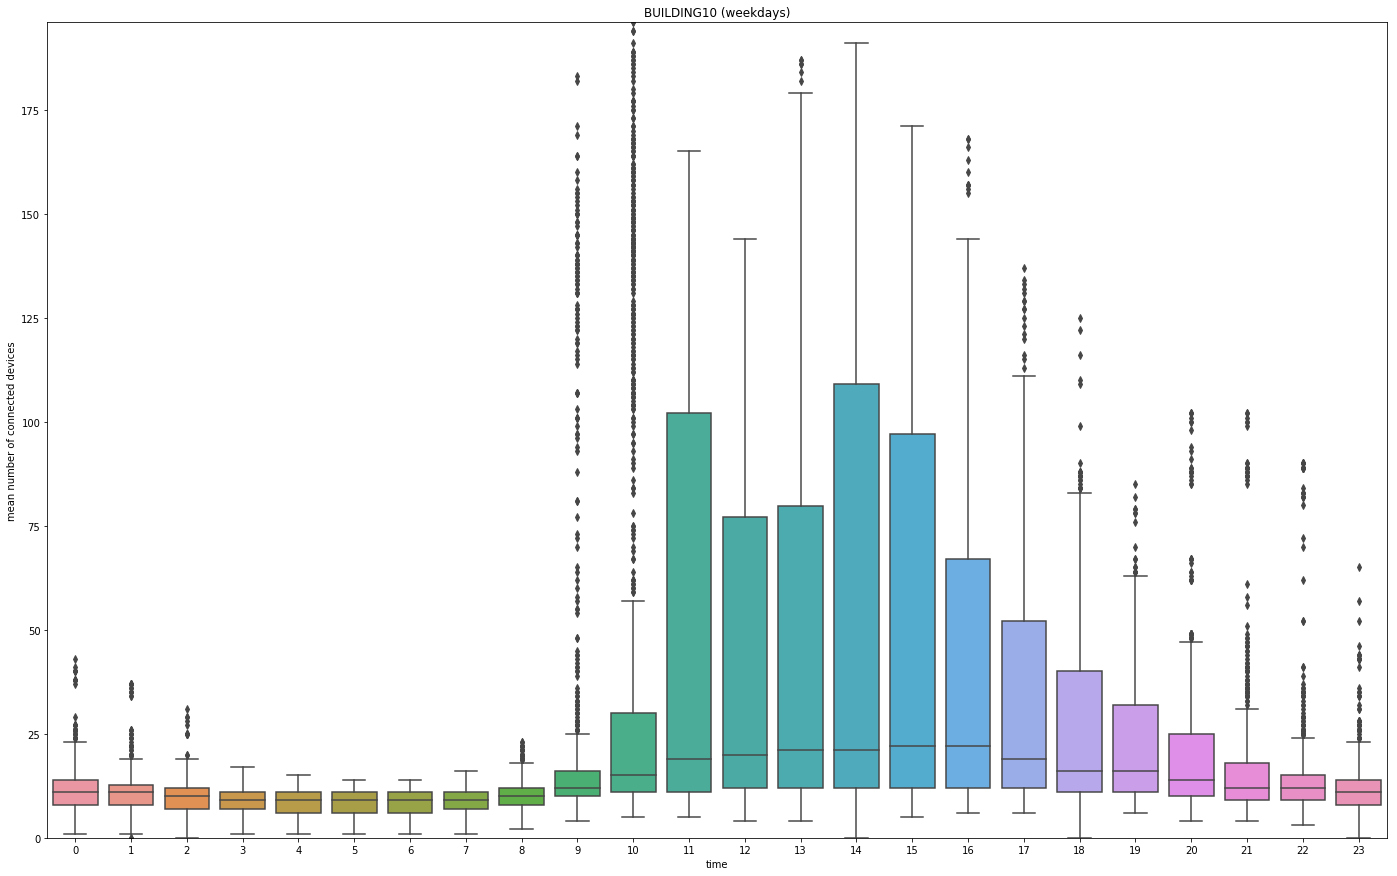

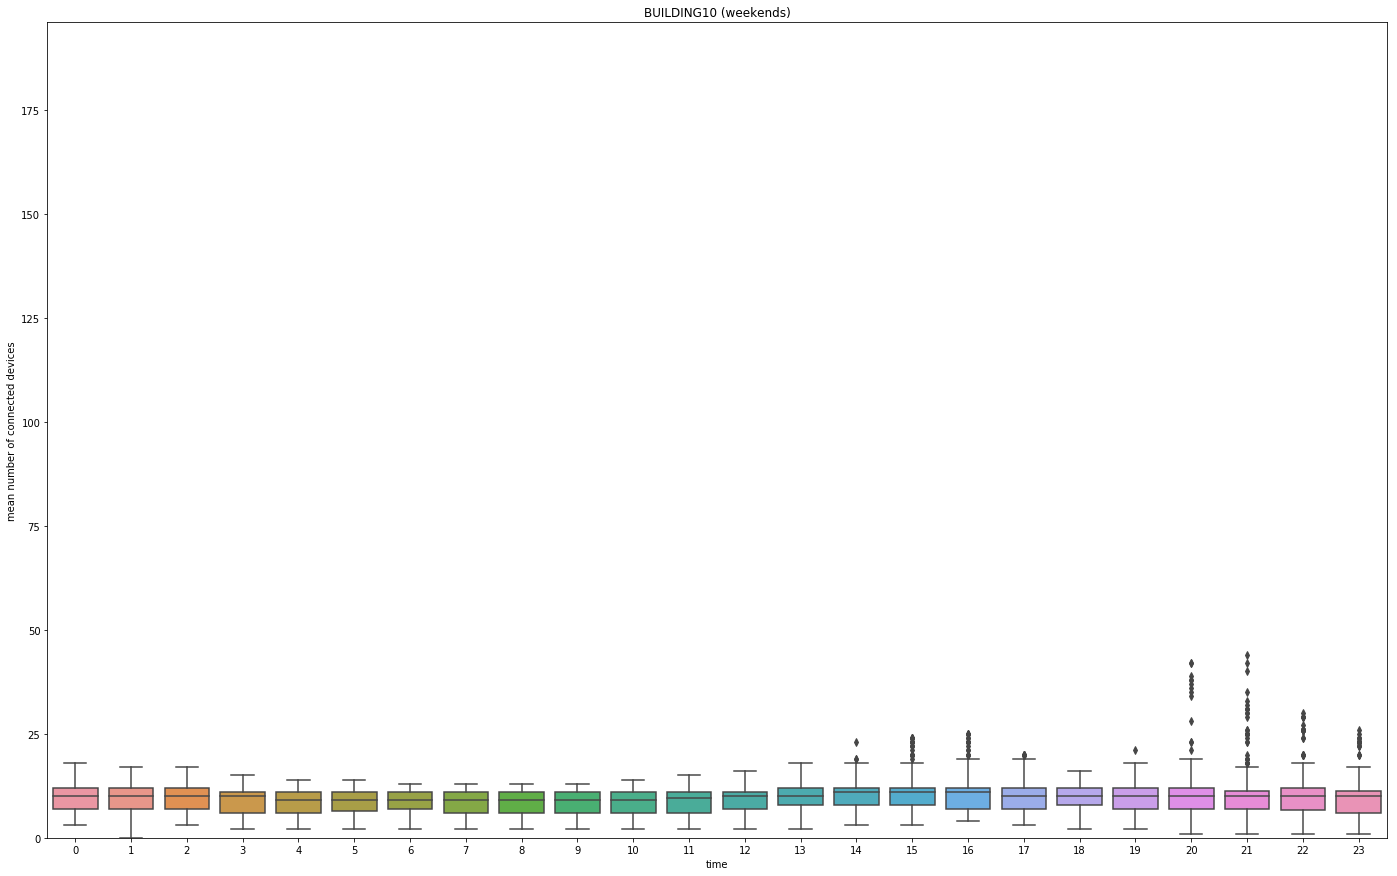

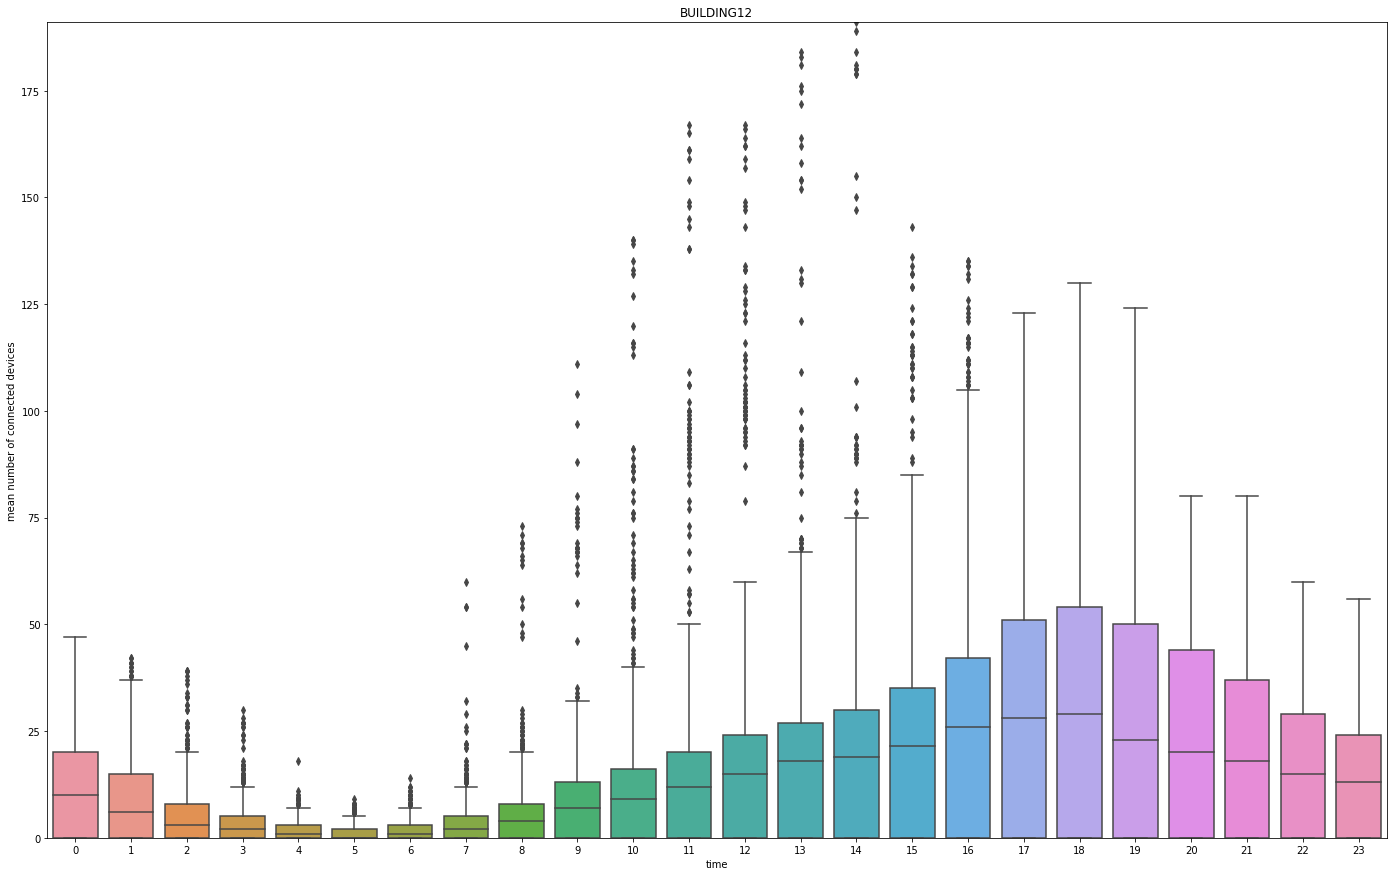

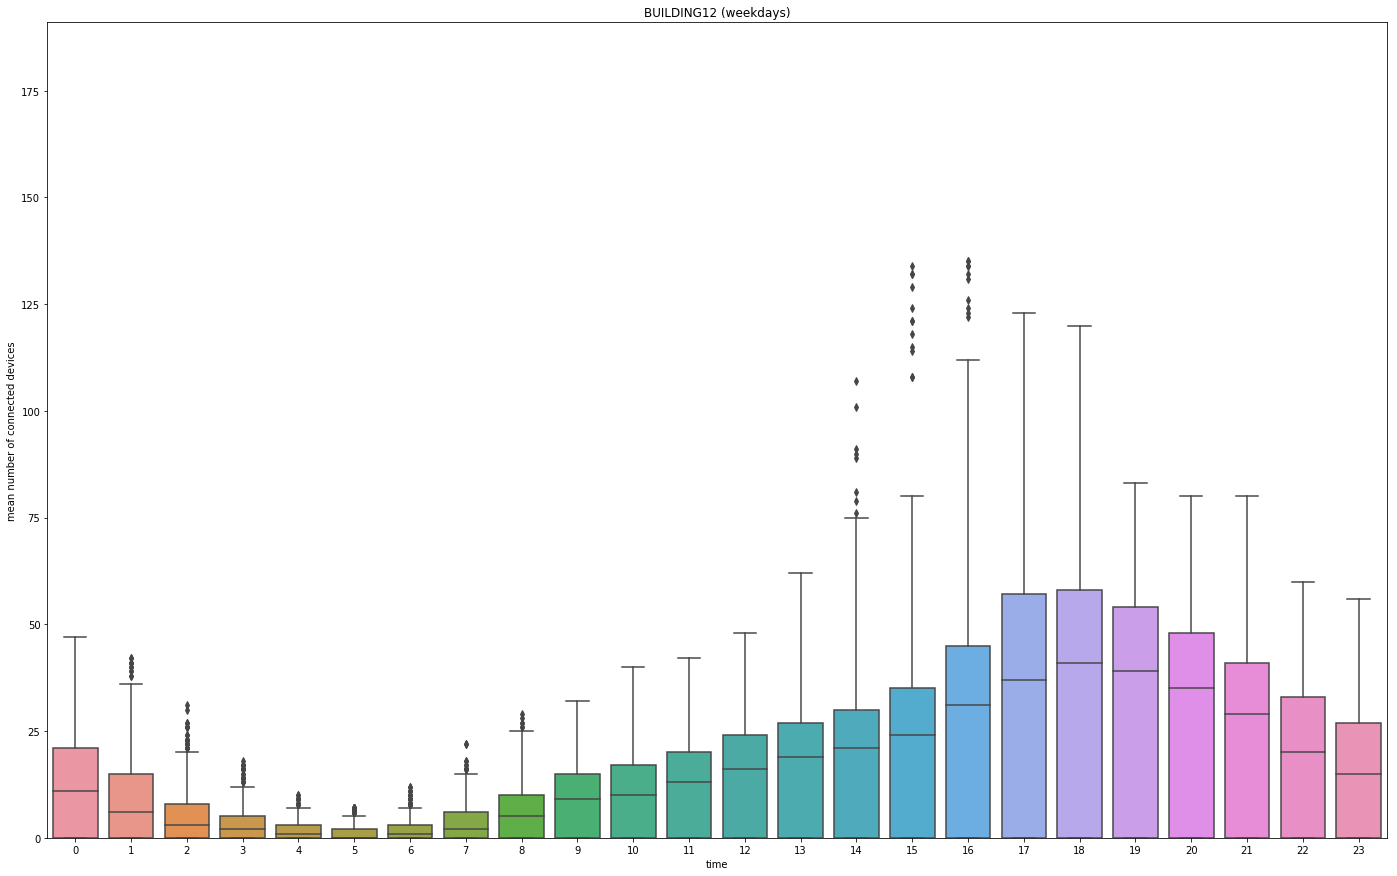

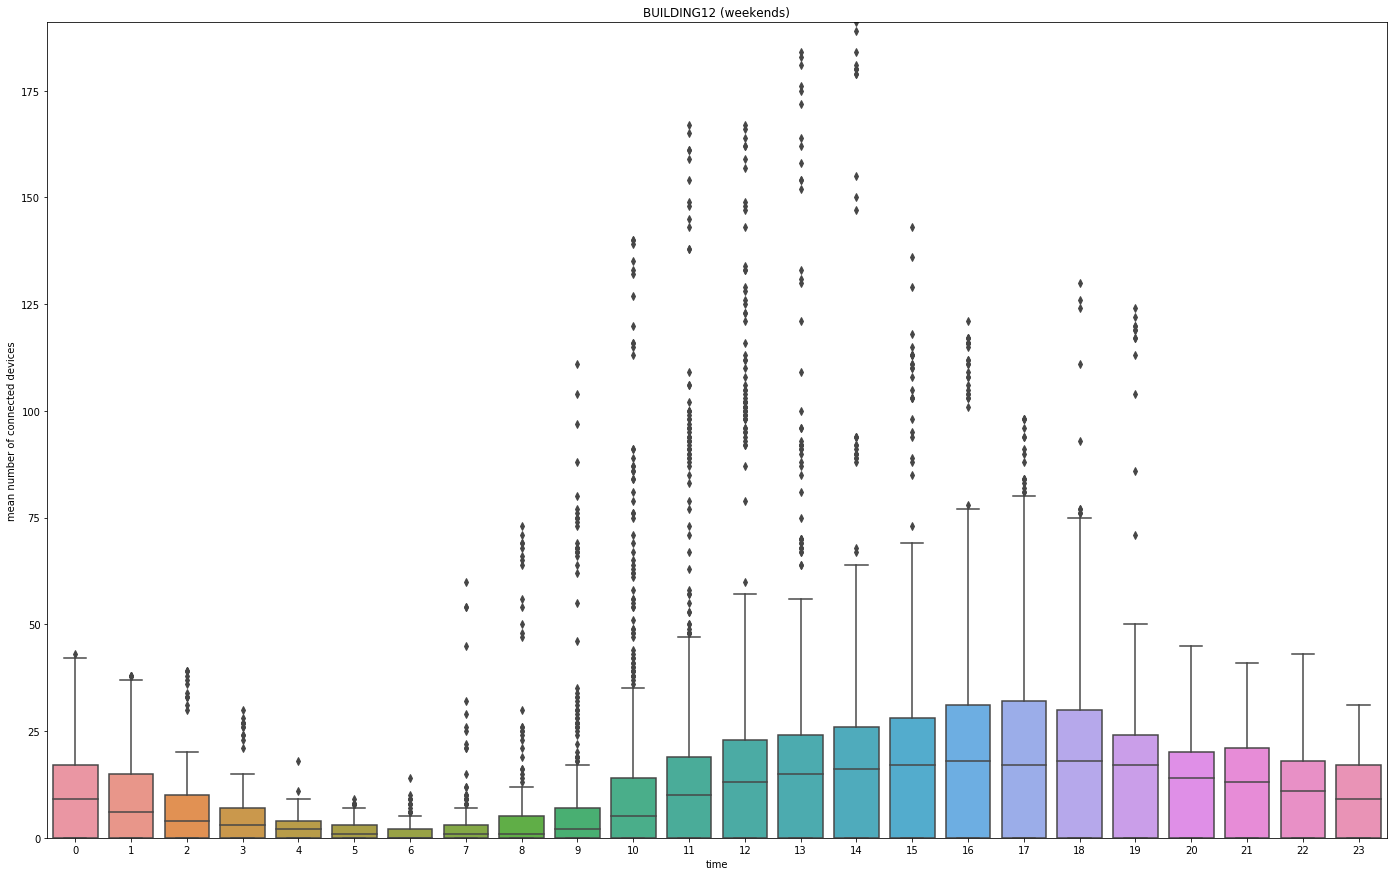

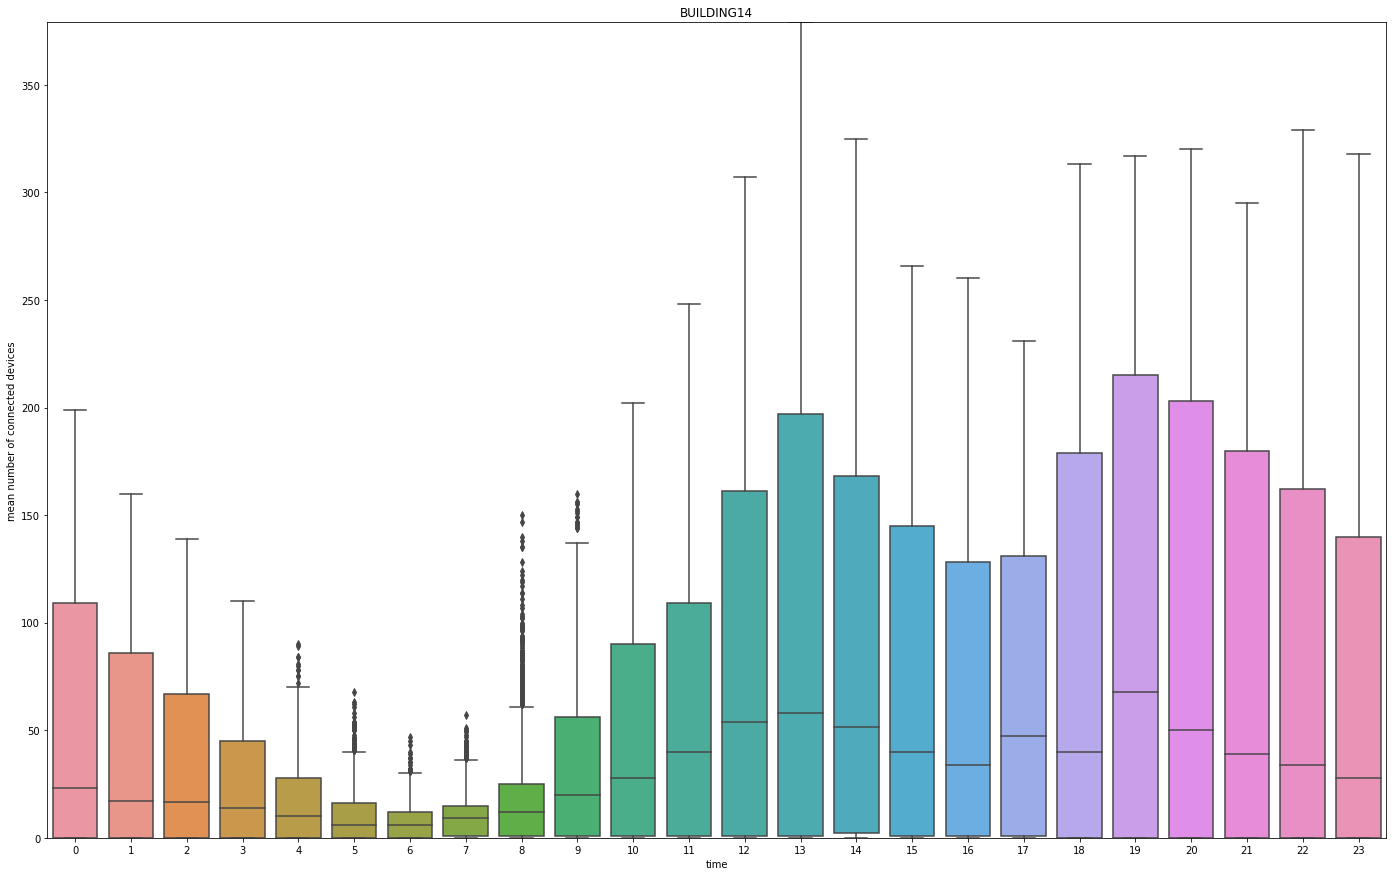

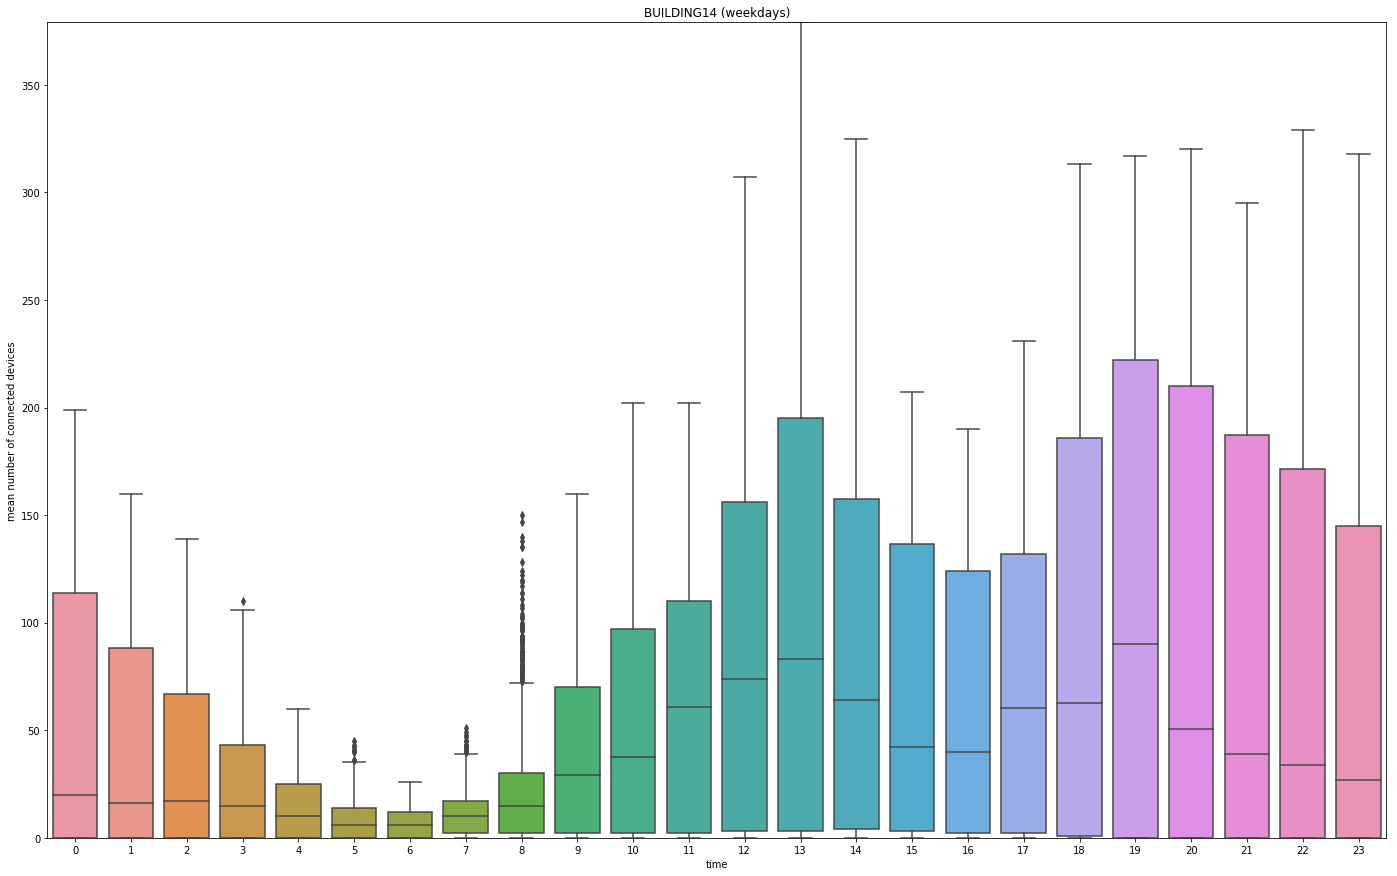

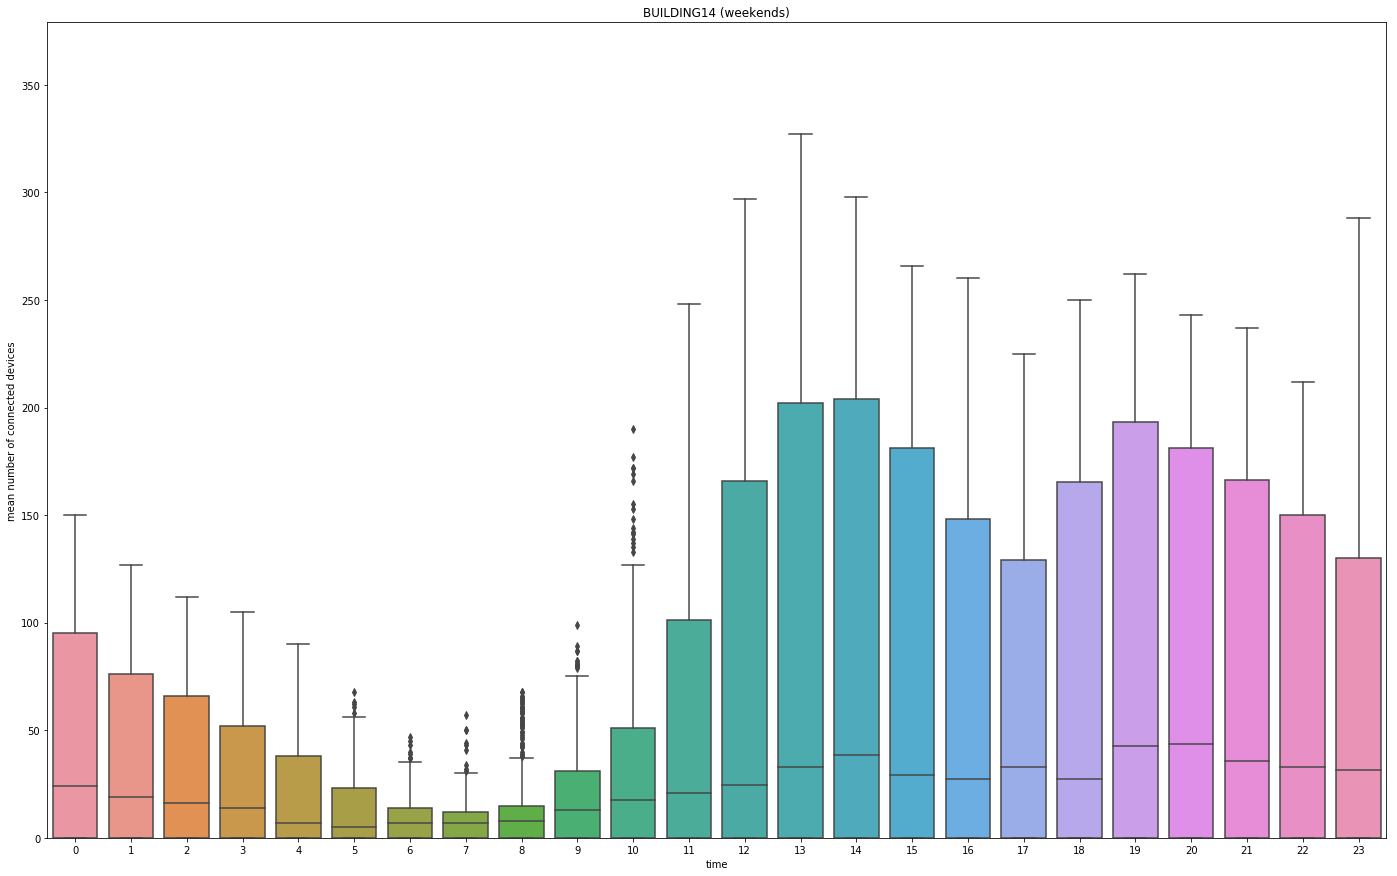

In [24]:
if(boxplot_hourly_average == True):
    # We need the total occupancy timeseries for each building.
    build_to_totals: Dict[Hashable, pd.Series] = {}

    # We need to find the maximum occupancy for a building at
    # any point in time to normalize the y-axes of the boxplots below.
    max_totals: Dict[Hashable, float] = defaultdict(lambda: NINF)

    for build in buildings:
        # get the total occupancy timeseries just for this building.
        build_totals = build_to_totals[build] = dfm.row_totals(
            occ_bybuild.get_group(build)
        )
        # search for a new max.
        newmax = build_totals.max().squeeze()
        if newmax > max_totals[build]:
            max_totals[build] = newmax

    for build in buildings:
        # get the total occupancy timeseries just for this building.
        build_totals: pd.DataFrame = build_to_totals[build]

        common_args = {
            'xlabel': 'hour of the day',
            'ylabel': 'mean number of connected devices',
            'ymax': max_totals[build], 
            'figsize': (24, 15)
        }

        # Overall boxplot.
        display_and_save_hourly_boxplot(
            tseries=build_totals,
            title=build,
            figfilepath='./{}.png'.format(build),
            **common_args
        )

        # Prints graph of weekday average occupancy per hour of each each building 
        try:
            # Weekdays boxplot.
            display_and_save_hourly_boxplot(
                tseries=build_totals.loc[build_totals.index.dayofweek < 5],
                title=build+' (weekdays)',
                figfilepath='./{}-wkdays.png'.format(build),
                **common_args
            )
        except Exception as e:
            print("No weekdays dates available in data set. Error: {}".format(e))
            raise e

        # Prints graph of weekend average occupancy per hour of each each building 
        try:
            # Weedends boxplot.
            display_and_save_hourly_boxplot(
                tseries=build_totals.loc[build_totals.index.dayofweek >= 5],
                title=build+' (weekends)',
                figfilepath='./{}-wkends.png'.format(build),
                **common_args
            )
        except Exception as e:
            print("No weekend dates available in data set. Error: {}".format(e))
            raise e

## Holidays

In [25]:
if (holiday_analysis == True):
    
    # Get all US holidays between time range
    holi_caldr = calendar()
    holidays = holi_caldr.holidays(start = start_date, end = end_date)

    # Shows what holidays are going to be included in this data set analysis 
    display(holidays)
    
    # Convert to date time inorder to compare with our df index
    holiday_ts = pd.to_datetime(holidays)

    truncated_time = occ.index.normalize()
    occ['time_no_timezone'] = truncated_time.tz_localize(None)
    
    # Check if the date matches our list of holidays
    occ['isHoliday'] = occ['time_no_timezone'].isin(holiday_ts)

    display(occ)

DatetimeIndex(['1970-01-01', '1970-02-16', '1970-05-25', '1970-07-03',
               '1970-09-07', '1970-10-12', '1970-11-11', '1970-11-26',
               '1970-12-25', '1971-01-01',
               ...
               '2030-01-01', '2030-01-21', '2030-02-18', '2030-05-27',
               '2030-07-04', '2030-09-02', '2030-10-14', '2030-11-11',
               '2030-11-28', '2030-12-25'],
              dtype='datetime64[ns]', length=594, freq=None)

,COL-BUILDING14-AP014,COL-BUILDING03-AP047,COL-BUILDING03-AP051,COL-BUILDING03-AP058,COL-BUILDING08-AP067,COL-BUILDING03-AP069,COL-BUILDING03-AP074,COL-BUILDING03-AP077,COL-BUILDING03-AP087,COL-BUILDING03-AP118,...,COL-BUILDING08-AP534,COL-BUILDING08-AP542,COL-BUILDING03-AP547,COL-BUILDING08-AP551,COL-BUILDING10-AP561,COL-BUILDING10-AP565,COL-BUILDING06-AP576,COL-BUILDING05-AP597,time_no_timezone,isHoliday
time,,,,,,,,,,,,,,,,,,,,,
2018-07-18 16:10:14-07:00,3.0,5.0,10.0,NaN,6.0,1.0,2.0,6.0,8.0,8.0,...,NaN,NaN,4.0,1.0,4.0,NaN,NaN,6.0,2018-07-18,False
2018-07-18 16:15:23-07:00,3.0,5.0,8.0,NaN,6.0,2.0,2.0,6.0,8.0,8.0,...,NaN,NaN,4.0,1.0,5.0,NaN,NaN,6.0,2018-07-18,False
2018-07-18 16:20:38-07:00,4.0,5.0,13.0,NaN,6.0,1.0,2.0,6.0,8.0,8.0,...,NaN,NaN,4.0,1.0,4.0,NaN,NaN,7.0,2018-07-18,False
2018-07-18 16:25:06-07:00,2.0,5.0,10.0,NaN,6.0,1.0,2.0,7.0,8.0,8.0,...,NaN,NaN,4.0,2.0,3.0,NaN,NaN,5.0,2018-07-18,False
2018-07-18 16:30:06-07:00,2.0,6.0,9.0,NaN,6.0,1.0,2.0,7.0,8.0,8.0,...,NaN,NaN,5.0,1.0,3.0,NaN,NaN,4.0,2018-07-18,False
2018-07-18 16:35:08-07:00,2.0,7.0,13.0,NaN,10.0,1.0,2.0,3.0,10.0,8.0,...,NaN,NaN,5.0,1.0,3.0,NaN,NaN,6.0,2018-07-18,False
2018-07-18 16:40:12-07:00,2.0,7.0,13.0,NaN,10.0,1.0,0.0,2.0,8.0,7.0,...,NaN,NaN,5.0,1.0,3.0,NaN,NaN,5.0,2018-07-18,False
2018-07-18 16:45:16-07:00,2.0,5.0,27.0,NaN,11.0,2.0,0.0,3.0,8.0,9.0,...,NaN,NaN,5.0,1.0,3.0,NaN,NaN,5.0,2018-07-18,False
2018-07-18 16:50:19-07:00,3.0,5.0,23.0,NaN,14.0,1.0,0.0,3.0,7.0,6.0,...,NaN,NaN,5.0,1.0,3.0,1.0,NaN,5.0,2018-07-18,False


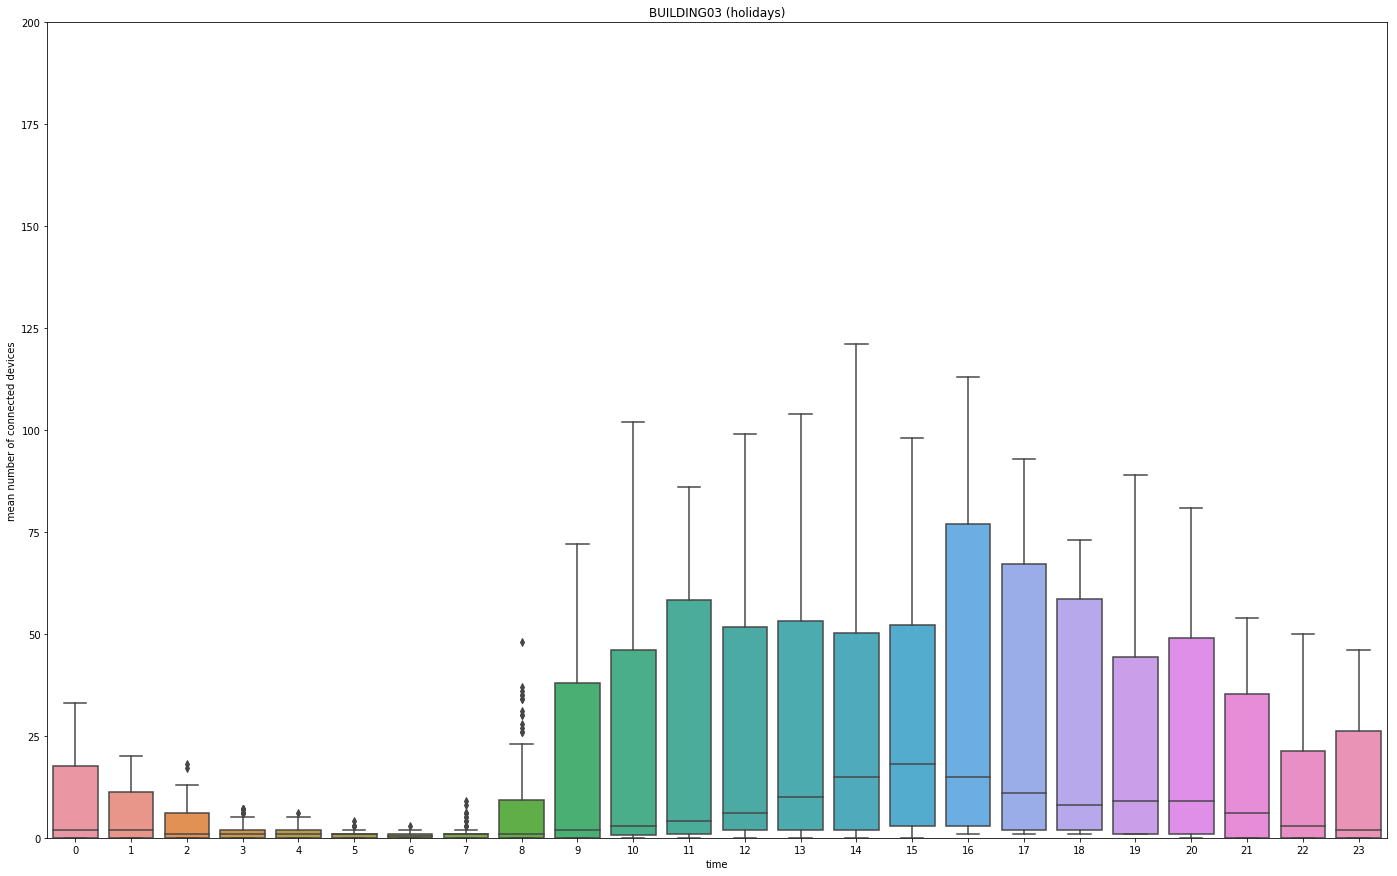

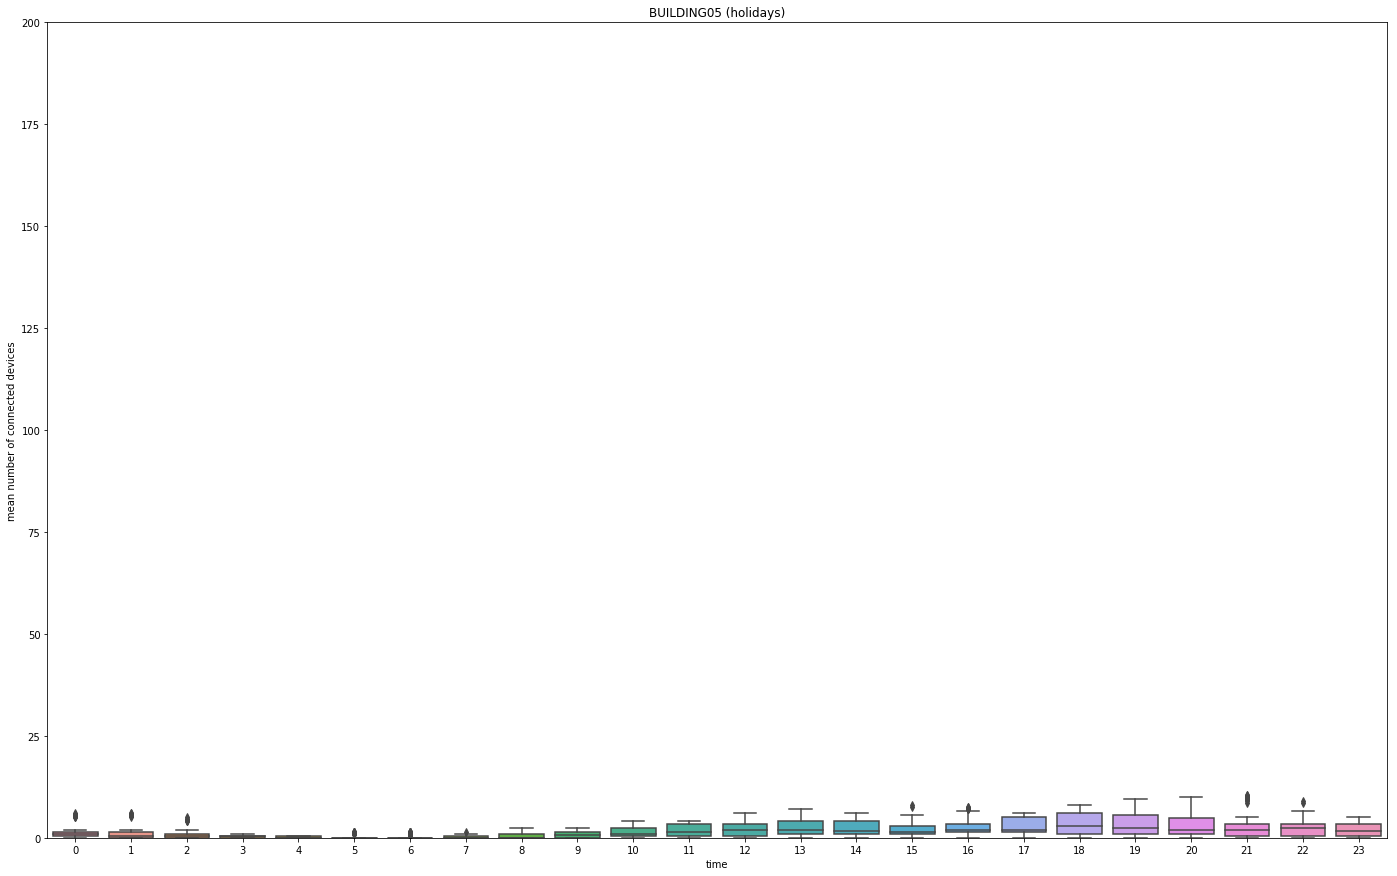

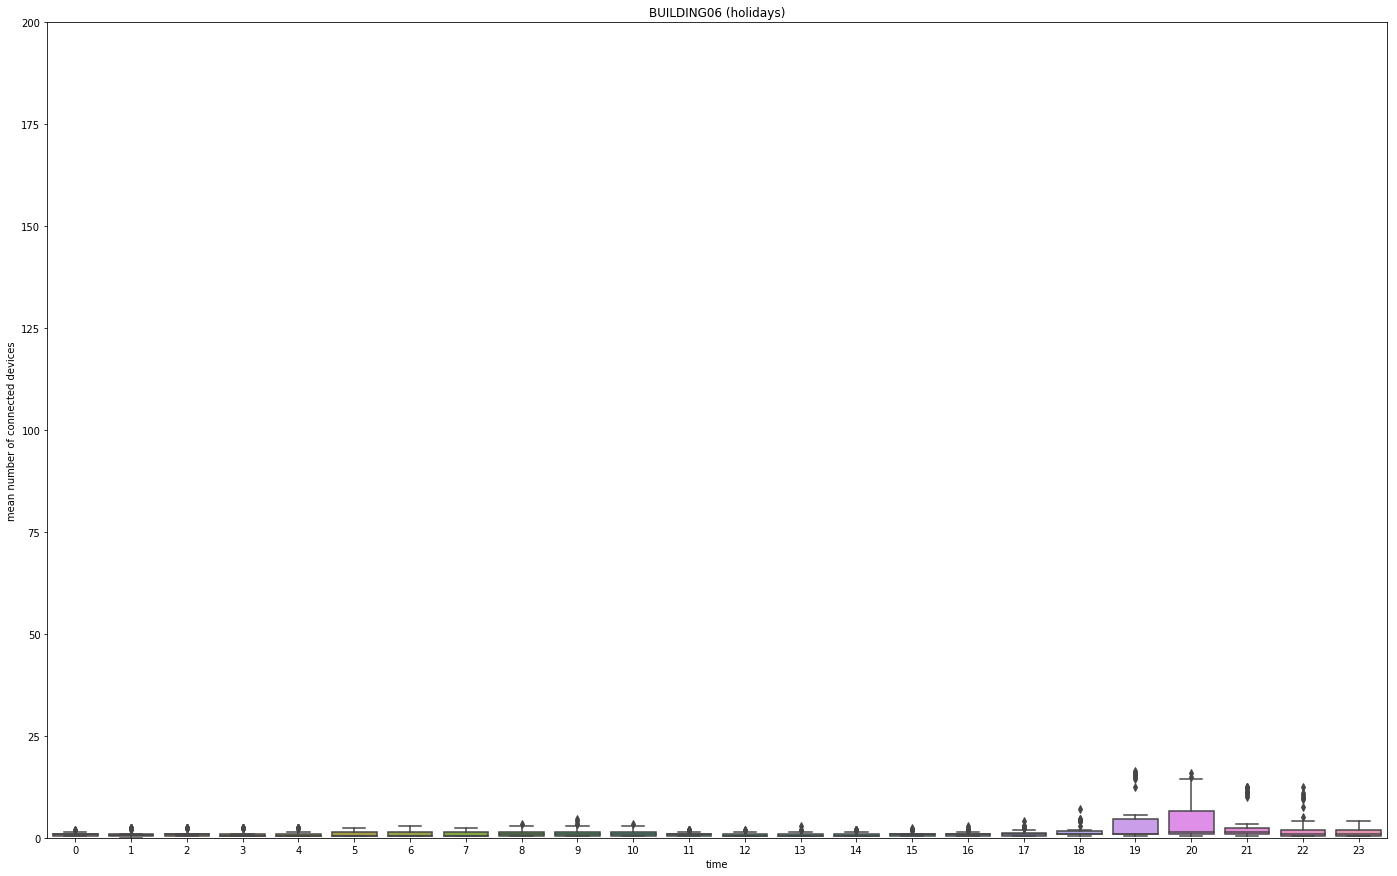

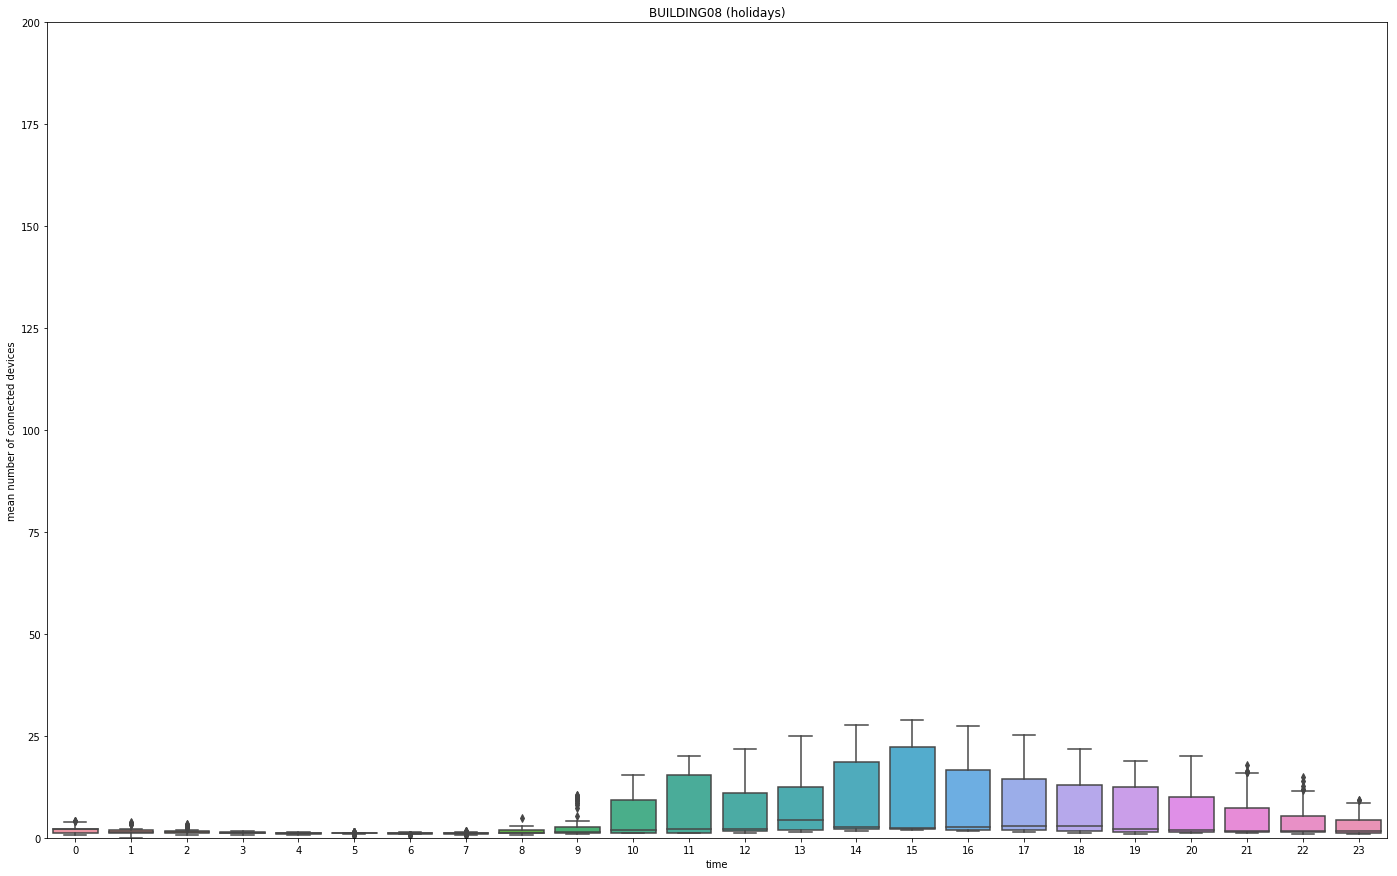

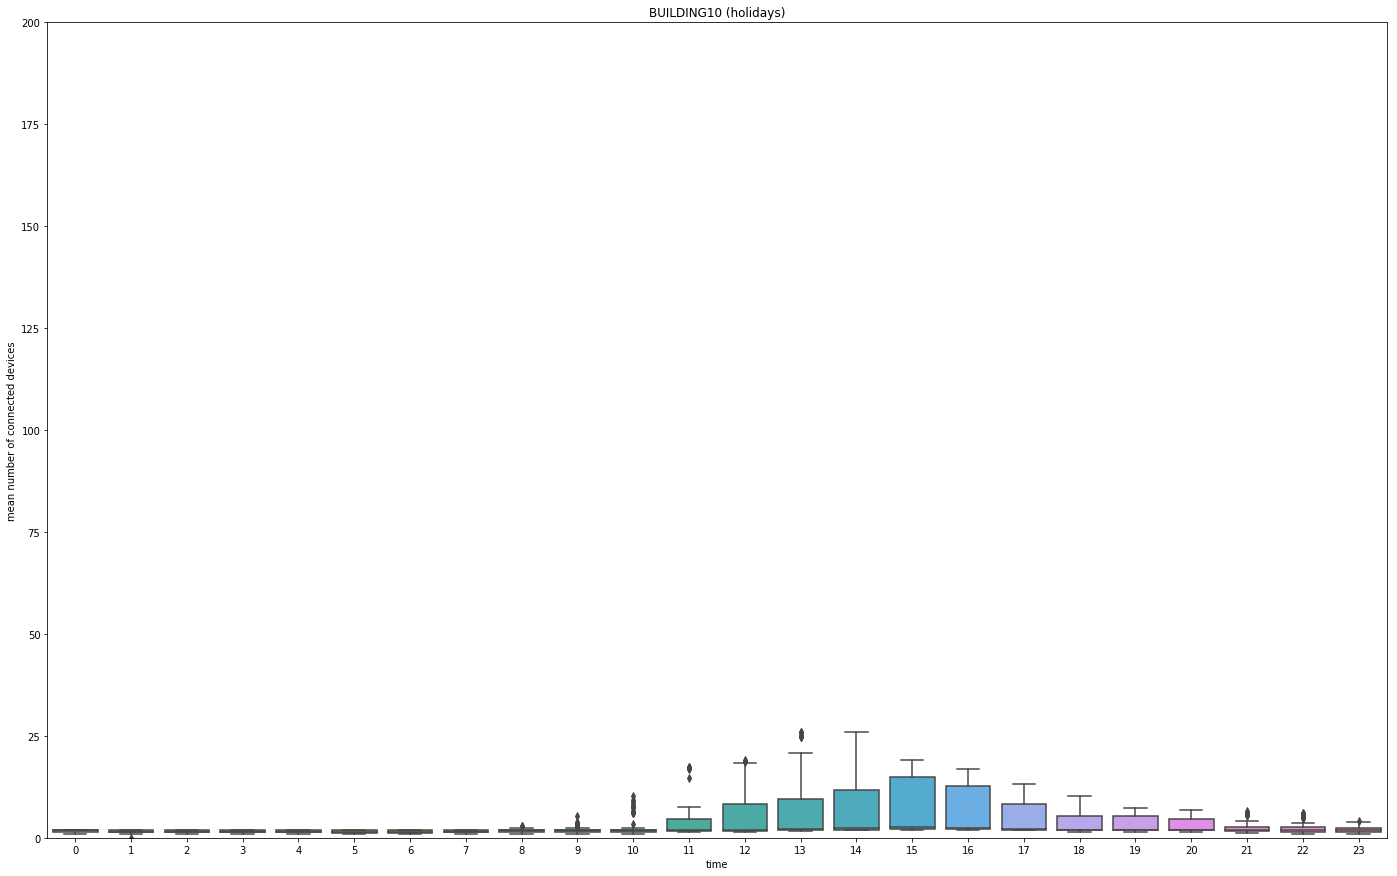

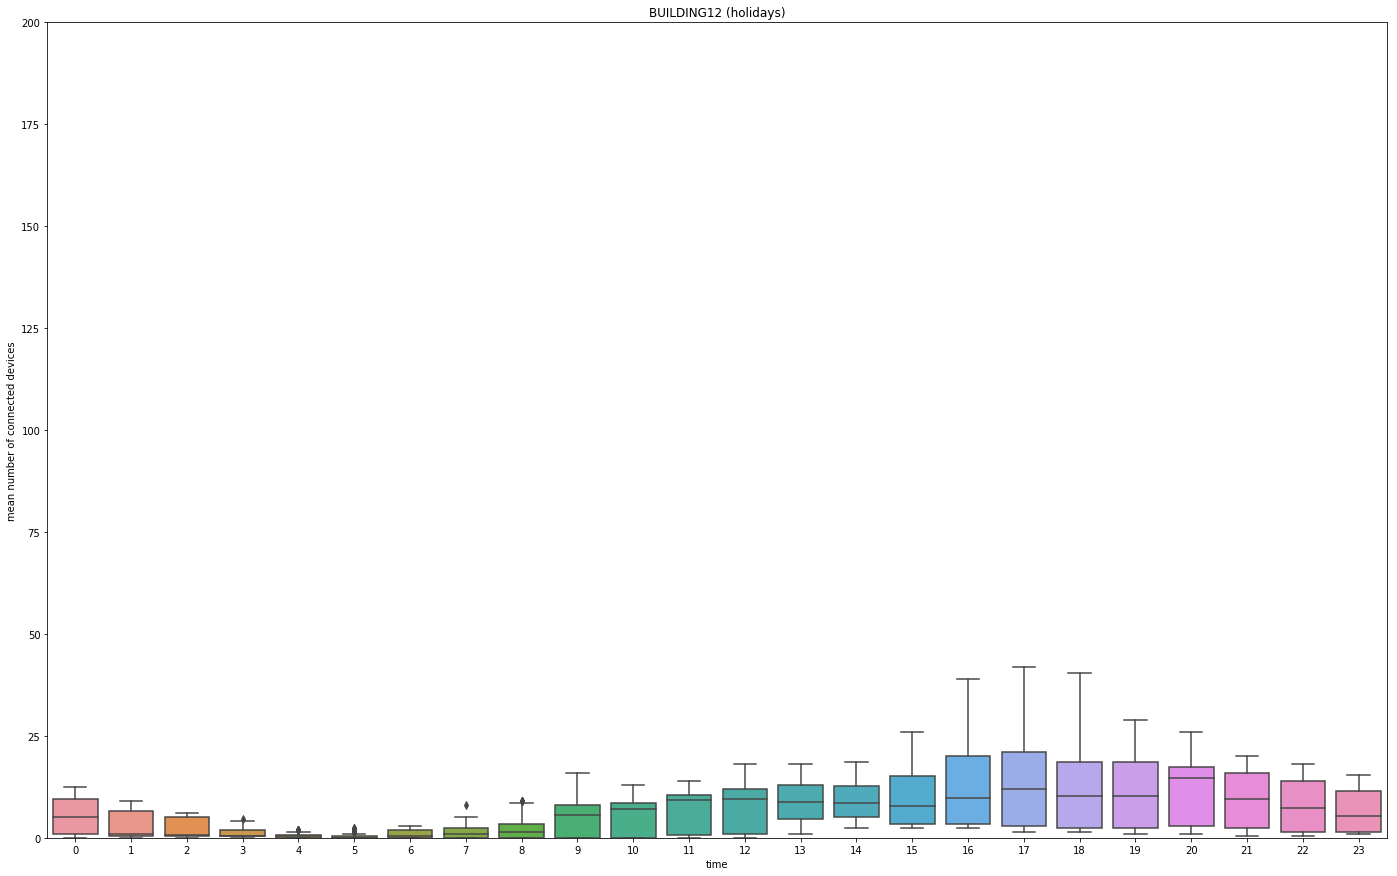

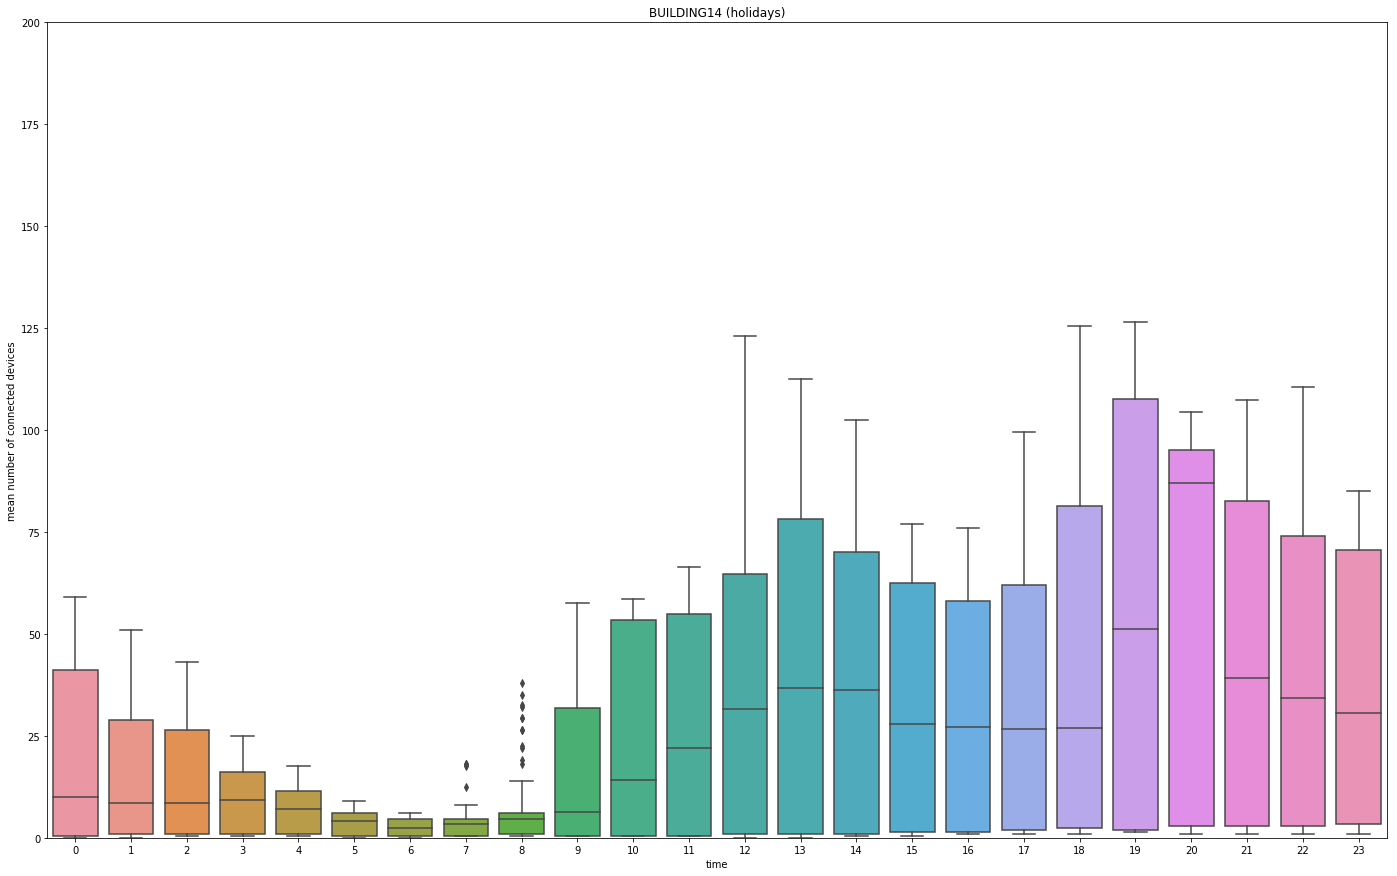

In [26]:
if (holiday_analysis == True):
    
    # Create a new df holiday_occ.
    # If the date is a holiday, copy the data to holiday_occ
    holiday_occ = occ.loc[occ['isHoliday'] == True]
    holiday_occ = holiday_occ.drop(['time_no_timezone', 'isHoliday'], axis =1)
    occ_holiday_bybuild = holiday_occ.groupby(
        by=schema.col_to_building, axis=1
    )

    means_by_building: Dict[Hashable, pd.DataFrame] = {}
    maxmean = float('-inf')
    for build in buildings:
        means_by_building[build] = dfm.row_means(occ_holiday_bybuild.get_group(build))
        newmax = means_by_building[build].max()
        newmin = means_by_building[build].min()
        maxmean = newmax if newmax > maxmean else maxmean

    for build in buildings:

         # Prints graph of holiday average occupancy per hour of each each building 
        try:
            mean_occ_holiday: pd.DataFrame = dfm.row_means(occ_holiday_bybuild.get_group(build))

            fig, ax = plt.subplots(figsize=(24, 15))

            title = '{} (holidays'.format(build)
            if start_date is not None:
                title += ' from ' + start_date
            if end_date is not None:
                title += ' to ' + end_date
            title += ')'
            ax.set_title(title)
            ax.set_xlabel('hour of the day')
            ax.set_ylabel('mean number of connected devices')
            ax.set_ylim(0, 200)

            seaborn.boxplot(
                # The hours (a number [0,23]) for each row.
                x=mean_occ_holiday.index.hour,
                # The total occupancy at that hour.
                y=mean_occ_holiday,
                ax=ax
            )
        except Exception as e:
            print("No holidays in this data set. Error: {}".format(e))
            raise e